### **Step 1: Import Libraries and Data Collection**

In [1]:
# ======================================================
# Step 1: Import Libraries & Setup
# ======================================================
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, 
                           average_precision_score, f1_score, 
                           precision_score, recall_score, accuracy_score)

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.nn import functional as F

# Additional utilities
import joblib
import pickle
import json
import time
from datetime import datetime
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Set style for visualisations
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# ======================================================
# Environment Setup & Configuration
# ======================================================

def setup_environment():
    """Setup the project environment and directory structure"""
    print("Setting up project environment...")
    
    # Create necessary directories
    directories = [
        'data',
        'models',
        'saved_models',
        'saved_artifacts',
        'notebooks',
        'figures',
        'logs',
        'tests'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"✓ Created directory: {directory}/")
    
    return True

def check_gpu_availability():
    """Check if GPU is available for training"""
    print("\nChecking hardware configuration...")
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # GB
        print(f"GPU available: {gpu_name}")
        print(f"GPU Memory: {gpu_memory:.1f} GB")
        print(f"CUDA version: {torch.version.cuda}")
    else:
        device = torch.device('cpu')
        print("Using CPU for computation")
        print("Note: Training will be slower without GPU acceleration")
    
    print(f"PyTorch version: {torch.__version__}")
    return device

# Execute environment setup
setup_success = setup_environment()
device = check_gpu_availability()

print("\n Environment setup completed successfully!")

Setting up project environment...
✓ Created directory: data/
✓ Created directory: models/
✓ Created directory: saved_models/
✓ Created directory: saved_artifacts/
✓ Created directory: notebooks/
✓ Created directory: figures/
✓ Created directory: logs/
✓ Created directory: tests/

Checking hardware configuration...
Using CPU for computation
Note: Training will be slower without GPU acceleration
PyTorch version: 2.9.1+cpu

 Environment setup completed successfully!


In [3]:
# ======================================================
# Data Loading & Initial Exploration
# ======================================================

def load_dataset(file_path='data/creditcard.csv'):
    """
    Load the credit card fraud dataset from the specified path
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: Loaded dataset
    """
    print(f"Loading dataset from: {file_path}")
    
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset file not found at: {file_path}")
    
    try:
        # Load the dataset with progress indication
        print("Loading data...", end=' ')
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        
        # Basic information about the dataset
        print(f"✓ Dataset shape: {df.shape}")
        print(f"✓ Number of features: {df.shape[1] - 1}")  # Excluding target
        print(f"✓ Number of samples: {df.shape[0]:,}")
        
        return df
        
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        raise

# Load the dataset
df = load_dataset('data/creditcard.csv')

# Display initial dataset information
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

print(f"\nFirst 5 rows of the dataset:")
display(df.head())

print(f"\nDataset columns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")

Loading dataset from: data/creditcard.csv
Loading data... 

Dataset loaded successfully!
✓ Dataset shape: (284807, 31)
✓ Number of features: 30
✓ Number of samples: 284,807

DATASET OVERVIEW

First 5 rows of the dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Dataset columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [4]:
# ======================================================
# Data Quality Checks
# ======================================================

def perform_data_quality_checks(df):
    """
    Perform comprehensive data quality checks on the dataset
    
    Parameters:
    df (pandas.DataFrame): The dataset to check
    
    Returns:
    pandas.DataFrame: Cleaned dataset
    """
    print("Performing data quality checks...") 
    
    # 1. Check for missing values
    print("\n1. Missing Values Analysis:")
    print("-" * 30)
    missing_values = df.isnull().sum()
    total_missing = missing_values.sum()
    
    if total_missing == 0:
        print("✓ No missing values found in the dataset")
    else:
        print(f"✗ Missing values found: {total_missing}")
        for col, count in missing_values[missing_values > 0].items():
            print(f"   - {col}: {count} missing values ({count/len(df)*100:.2f}%)")
    
    # 2. Check for duplicate rows
    print("\n2. Duplicate Rows Analysis:")
    print("-" * 30)
    duplicates = df.duplicated().sum()
    if duplicates == 0:
        print("✓ No duplicate rows found")
    else:
        print(f"✗ {duplicates} duplicate rows found ({duplicates/len(df)*100:.2f}%)")
        # Remove duplicates
        df = df.drop_duplicates()
        print(f"✓ Removed duplicates. New shape: {df.shape}")
    
    # 3. Check for infinite values
    print("\n3. Infinite Values Check:")
    print("-" * 30)
    infinite_values = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
    if infinite_values == 0:
        print("✓ No infinite values found")
    else:
        print(f"✗ {infinite_values} infinite values found")
    
    # 4. Check for constant columns
    print("\n4. Constant Columns Check:")
    print("-" * 30)
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    if not constant_columns:
        print("✓ No constant columns found")
    else:
        print(f"✗ Constant columns found: {constant_columns}")
    
    return df

# Perform data quality checks
df = perform_data_quality_checks(df)

Performing data quality checks...

1. Missing Values Analysis:
------------------------------
✓ No missing values found in the dataset

2. Duplicate Rows Analysis:
------------------------------
✗ 1081 duplicate rows found (0.38%)
✓ Removed duplicates. New shape: (283726, 31)

3. Infinite Values Check:
------------------------------
✓ No infinite values found

4. Constant Columns Check:
------------------------------
✓ No constant columns found


In [5]:
# ======================================================
# Feature Analysis
# ======================================================

def analyse_features(df):
    """
    Perform initial analysis of dataset features
    
    Parameters:
    df (pandas.DataFrame): The dataset
    """
    print("\nAnalysing features...")
    
    # Separate features and target
    features = df.drop('Class', axis=1)
    target = df['Class']
    
    print("=" * 50)
    print("FEATURE ANALYSIS")
    print("=" * 50)
    
    # Basic statistics
    print("\n1. Basic Statistics for Numerical Features:")
    print("-" * 40)
    display(features.describe())
    
    # Check data types
    print("\n2. Data Types:")
    print("-" * 20)
    print(features.dtypes)
    
    # Check for PCA features (V1-V28)
    pca_features = [f'V{i}' for i in range(1, 29) if f'V{i}' in features.columns]
    non_pca_features = [col for col in features.columns if col not in pca_features and col != 'Class']
    
    print(f"\n3. PCA-transformed features (V1-V28): {len(pca_features)} features")
    print(f"4. Non-PCA features: {non_pca_features}")
    
    # Analyse Amount and Time features
    print("\n5. Amount Feature Analysis:")
    print("-" * 30)
    amount_stats = features['Amount'].describe()
    print(f"   Min: {amount_stats['min']:.2f}")
    print(f"   Max: {amount_stats['max']:.2f}")
    print(f"   Mean: {amount_stats['mean']:.2f}")
    print(f"   Std: {amount_stats['std']:.2f}")
    
    print("\n6. Time Feature Analysis:")
    print("-" * 30)
    time_stats = features['Time'].describe()
    print(f"   Min: {time_stats['min']:.2f} seconds")
    print(f"   Max: {time_stats['max']:.2f} seconds")
    print(f"   Mean: {time_stats['mean']:.2f} seconds")
    print(f"   ({time_stats['mean']/3600:.1f} hours)")
    
    return features, target

from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# If you want to analyse the test set features

print("\nBasic statistics for test set features:")
display(pd.DataFrame(X_test).describe())


Basic statistics for test set features:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,...,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000
mean,94454.496722,0.009476,0.001520,-0.000459,-0.006730,-0.010626,0.002146,0.003085,-0.003413,0.003552,...,-0.001660,-0.006127,-0.000368,0.001912,0.000904,-0.002148,-0.000478,0.002089,-0.001054,88.814933
std,47451.115498,1.950968,1.634998,1.514327,1.403031,1.444329,1.365524,1.331946,1.217134,1.101218,...,0.810533,0.730477,0.725294,0.615650,0.604875,0.519568,0.484717,0.415767,0.336981,268.131582
min,2.000000,-37.558067,-38.305310,-48.325589,-5.416315,-113.743307,-21.929312,-33.239328,-50.688419,-10.842526,...,-54.497720,-22.889347,-7.105990,-36.666000,-2.766638,-6.712624,-1.715640,-9.895244,-15.430084,0.000000
25%,54059.000000,-0.916543,-0.597568,-0.897331,-0.853980,-0.691636,-0.769724,-0.552502,-0.209729,-0.643965,...,-0.210928,-0.229364,-0.546949,-0.159037,-0.352908,-0.316651,-0.327523,-0.071009,-0.053493,5.490000
50%,84470.000000,0.029038,0.064518,0.186424,-0.023224,-0.058079,-0.272845,0.040898,0.020619,-0.048966,...,-0.062994,-0.032642,0.004138,-0.009930,0.040616,0.016764,-0.054226,0.001358,0.010534,21.585000
75%,139035.000000,1.318946,0.796301,1.025895,0.732642,0.600157,0.393584,0.564698,0.326667,0.603520,...,0.131905,0.183733,0.526069,0.146160,0.438291,0.348999,0.241373,0.090439,0.076436,76.497500
max,172786.000000,2.430507,16.697832,3.924953,15.304184,32.911462,73.301626,120.589494,15.794136,10.392889,...,24.133894,20.063786,8.272233,19.002942,4.584549,4.808122,3.463246,31.612198,15.866721,25691.160000


In [6]:
# ======================================================
# Save Dataset Information
# ======================================================

def save_dataset_info(df, output_path='data/dataset_info.txt'):
    """
    Save dataset information to a text file for documentation
    
    Parameters:
    df (pandas.DataFrame): The dataset
    output_path (str): Path to save the information
    """
    with open(output_path, 'w') as f:
        f.write("CREDIT CARD FRAUD DATASET INFORMATION\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"Dataset Shape: {df.shape}\n")
        f.write(f"Number of Features: {df.shape[1] - 1}\n")
        f.write(f"Number of Samples: {df.shape[0]}\n\n")
        
        f.write("CLASS DISTRIBUTION:\n")
        f.write("-" * 20 + "\n")
        class_dist = df['Class'].value_counts()
        fraud_percentage = (class_dist[1] / len(df)) * 100
        f.write(f"Non-fraudulent (Class 0): {class_dist[0]:,}\n")
        f.write(f"Fraudulent (Class 1): {class_dist[1]:,}\n")
        f.write(f"Fraud Percentage: {fraud_percentage:.6f}%\n")
        f.write(f"Imbalance Ratio: {class_dist[0]/class_dist[1]:.1f}:1\n\n")
        
        f.write("MISSING VALUES:\n")
        f.write("-" * 15 + "\n")
        missing = df.isnull().sum()
        for col, count in missing.items():
            f.write(f"{col}: {count}\n")
        f.write(f"\nTotal Missing Values: {missing.sum()}\n\n")
        
        f.write("DUPLICATE ROWS:\n")
        f.write("-" * 15 + "\n")
        duplicates = df.duplicated().sum()
        f.write(f"Duplicate Rows: {duplicates}\n\n")
        
        f.write("DATA TYPES:\n")
        f.write("-" * 12 + "\n")
        for col, dtype in df.dtypes.items():
            f.write(f"{col}: {dtype}\n")
        
        f.write("\nFEATURE CORRELATION WITH TARGET:\n")
        f.write("-" * 30 + "\n")
        target_corr = df.corr()['Class'].drop('Class').sort_values(ascending=False)
        for feature, corr in target_corr.items():
            f.write(f"{feature}: {corr:.4f}\n")
    
    print(f"✓ Dataset information saved to: {output_path}")

# Save dataset information
save_dataset_info(df)

print("\n" + "="*70)
print("STEP 1 COMPLETED SUCCESSFULLY!")
print("="*70)
print("✓ Environment setup complete")
print("✓ Libraries imported")
print("✓ Dataset loaded and verified")
print("✓ Data quality checks performed")
print("✓ Dataset information documented")
print("✓ Ready for Step 2: Exploratory Data Analysis and Data Preprocessing")

✓ Dataset information saved to: data/dataset_info.txt

STEP 1 COMPLETED SUCCESSFULLY!
✓ Environment setup complete
✓ Libraries imported
✓ Dataset loaded and verified
✓ Data quality checks performed
✓ Dataset information documented
✓ Ready for Step 2: Exploratory Data Analysis and Data Preprocessing


### **Step 2: Exploratory Data Analysis (EDA) and Data Preprocessing**
In this step, we work with the credit card dataset (`data/creditcard.csv`) to perform exploratory data analysis (EDA) and prepare it for modelling. The EDA process involves examining data types, statistical summaries, class distribution, correlations, and visualisations to identify underlying patterns and potential anomalies. Afterward, we preprocess the dataset by handling missing values, scaling numerical features, addressing class imbalance through techniques like SMOTE, undersampling, or class weighting, and splitting the data into training, validation, and test sets. This ensures the dataset is clean, balanced, and well-structured, providing a solid foundation for training the deep learning fraud detection models.

In [7]:
# ======================================================
# Step 2: Exploratory Data Analysis (EDA) and Data Preprocessing
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported for EDA and Data Preprocessing")

Libraries imported for EDA and Data Preprocessing


In [8]:
# ======================================================
# Load and Verify Dataset
# ======================================================

def load_and_verify_data(file_path='data/creditcard.csv'):
    """Load and verify the dataset integrity"""
    print("Loading and verifying dataset...")
    
    df = pd.read_csv(file_path)
    
    # Basic verification
    print(f"✓ Dataset shape: {df.shape}")
    print(f"✓ Columns: {list(df.columns)}")
    print(f"✓ Class distribution:\n{df['Class'].value_counts()}")
    print(f"✓ Fraud percentage: {(df['Class'].mean() * 100):.6f}%")
    
    return df

# Load the dataset
df = load_and_verify_data('data/creditcard.csv')
display(df.head())

Loading and verifying dataset...
✓ Dataset shape: (284807, 31)
✓ Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
✓ Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
✓ Fraud percentage: 0.172749%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# ======================================================
# Comprehensive EDA Functions
# ======================================================

def perform_comprehensive_eda(df):
    """Perform comprehensive exploratory data analysis"""
    print("="*60)
    print("COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    # 1. Basic dataset information
    print("\n1. DATASET INFORMATION:")
    print("-" * 30)
    df.info()
    
    # 2. Statistical summary
    print("\n2. STATISTICAL SUMMARY:")
    print("-" * 30)
    display(df.describe())
    
    # 3. Check for missing values
    print("\n3. MISSING VALUES ANALYSIS:")
    print("-" * 30)
    missing_values = df.isnull().sum()
    if missing_values.sum() == 0:
        print("✓ No missing values found")
    else:
        print("Missing values found:")
        for col, count in missing_values[missing_values > 0].items():
            print(f"  {col}: {count} ({count/len(df)*100:.2f}%)")
    
    # 4. Check for duplicates
    print("\n4. DUPLICATE ANALYSIS:")
    print("-" * 30)
    duplicates = df.duplicated().sum()
    if duplicates == 0:
        print("✓ No duplicate rows found")
    else:
        print(f"✗ {duplicates} duplicate rows found")
        df = df.drop_duplicates()
        print(f"✓ Removed duplicates. New shape: {df.shape}")
    
    return df

# Perform comprehensive EDA
df = perform_comprehensive_eda(df)

COMPREHENSIVE EXPLORATORY DATA ANALYSIS

1. DATASET INFORMATION:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  flo

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



3. MISSING VALUES ANALYSIS:
------------------------------
✓ No missing values found

4. DUPLICATE ANALYSIS:
------------------------------
✗ 1081 duplicate rows found
✓ Removed duplicates. New shape: (283726, 31)



5. CLASS DISTRIBUTION ANALYSIS:
----------------------------------------
Non-fraudulent (Class 0): 283,253 samples
Fraudulent (Class 1): 473 samples
Total samples: 283,726
Fraud percentage: 0.166710%
Imbalance ratio: 598.8:1


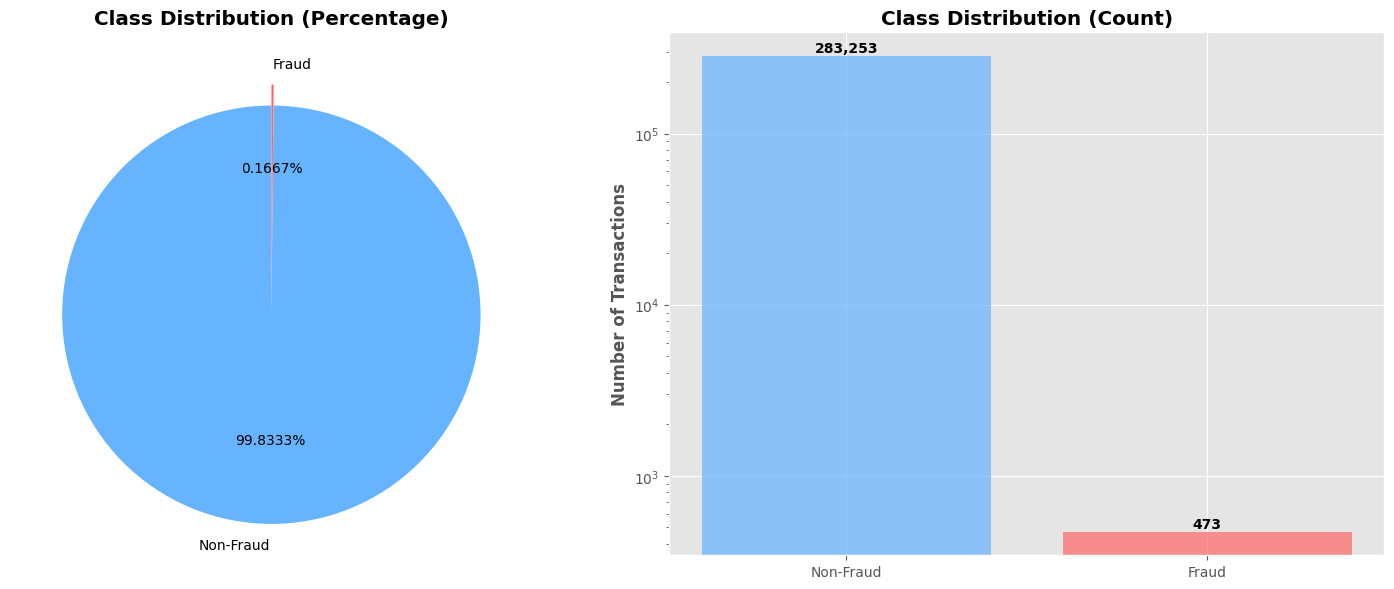

In [10]:
# ======================================================
# Class Distribution Analysis
# ======================================================

def analyse_class_distribution(df):
    """Detailed analysis of class distribution"""
    print("\n5. CLASS DISTRIBUTION ANALYSIS:")
    print("-" * 40)
    
    class_counts = df['Class'].value_counts()
    fraud_percentage = (class_counts[1] / len(df)) * 100
    
    print(f"Non-fraudulent (Class 0): {class_counts[0]:,} samples")
    print(f"Fraudulent (Class 1): {class_counts[1]:,} samples")
    print(f"Total samples: {len(df):,}")
    print(f"Fraud percentage: {fraud_percentage:.6f}%")
    print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pie chart
    colors = ['#66b3ff', '#ff6666']
    ax1.pie(class_counts, labels=['Non-Fraud', 'Fraud'], colors=colors,
            autopct='%1.4f%%', startangle=90, explode=(0.1, 0))
    ax1.set_title('Class Distribution (Percentage)', fontweight='bold')
    
    # Bar plot (log scale)
    bars = ax2.bar(['Non-Fraud', 'Fraud'], class_counts, color=colors, alpha=0.7)
    ax2.set_title('Class Distribution (Count)', fontweight='bold')
    ax2.set_ylabel('Number of Transactions', fontweight='bold')
    ax2.set_yscale('log')
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'{height:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('figures/class_distribution_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return class_counts

class_counts = analyse_class_distribution(df)


6. FEATURE DISTRIBUTION ANALYSIS:
----------------------------------------
Number of numerical features: 30
Numerical features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Number of numerical features: 30
Numerical features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


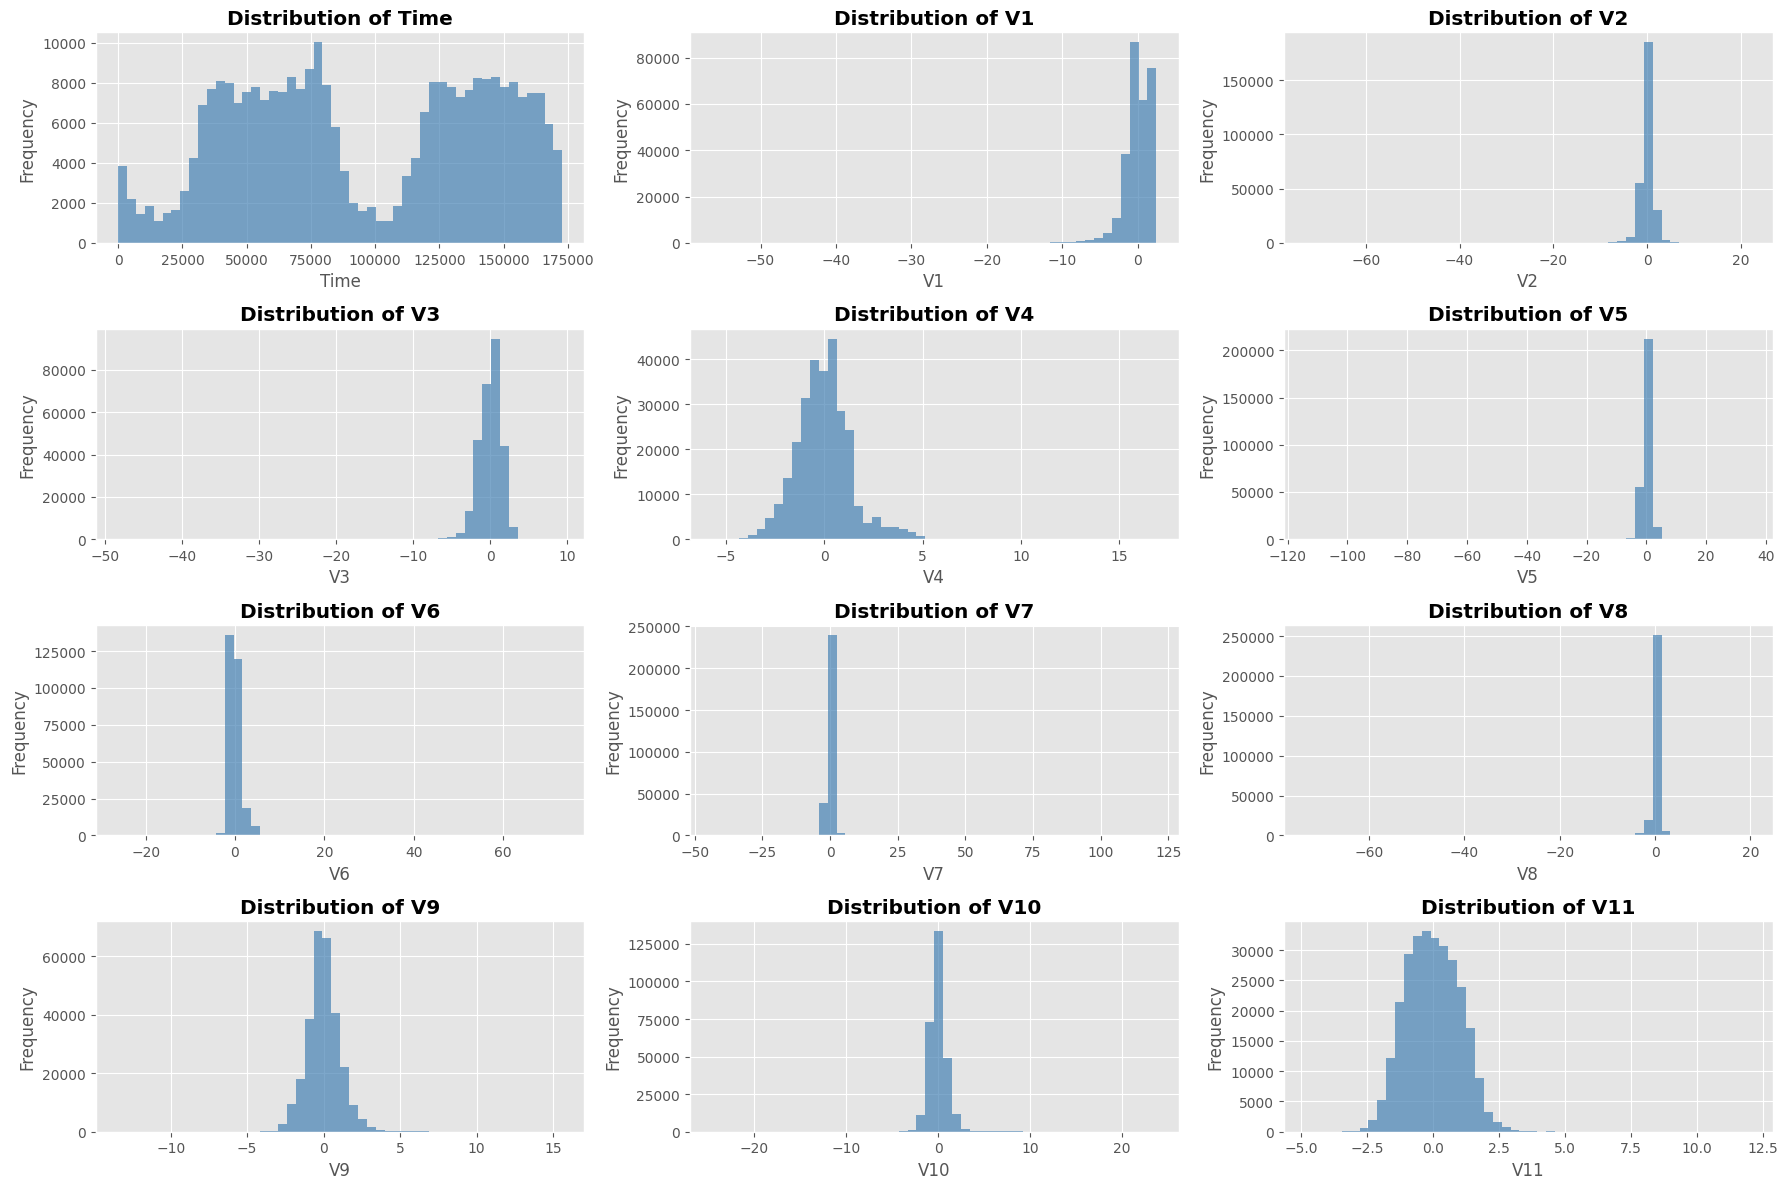

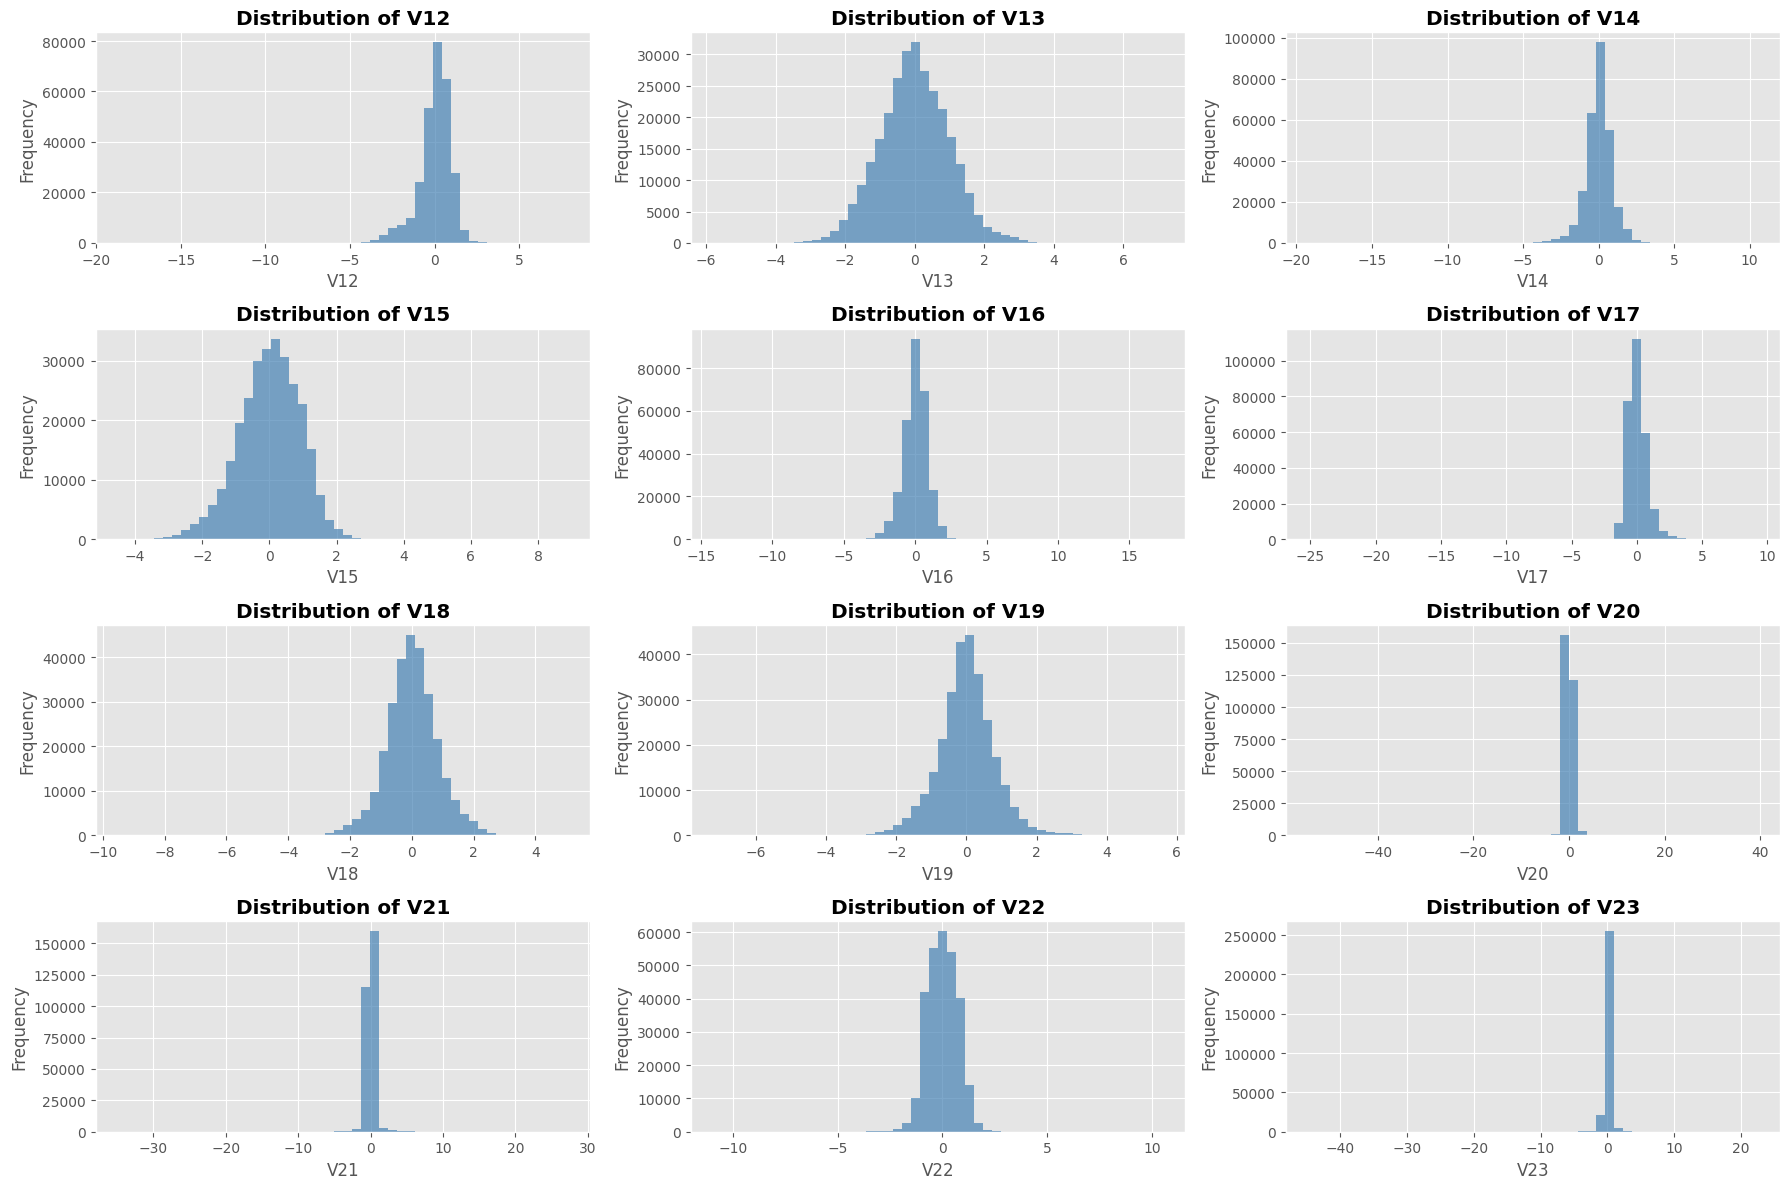

In [11]:
# ======================================================
# Feature Distribution Analysis
# ======================================================

def analyse_feature_distributions(df):
    """Analyse distributions of all features"""
    print("\n6. FEATURE DISTRIBUTION ANALYSIS:")
    print("-" * 40)
    
    # Separate features and target
    X = df.drop('Class', axis=1)
    y = df['Class']

    # Analyse numerical features
    numerical_features = X.select_dtypes(include=[np.number]).columns

    print(f"Number of numerical features: {len(numerical_features)}")
    print(f"Numerical features: {list(numerical_features)}")

    # Plot distributions of first 12 features
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    # Analyse numerical features
    numerical_features = X.select_dtypes(include=[np.number]).columns
    
    print(f"Number of numerical features: {len(numerical_features)}")
    print(f"Numerical features: {list(numerical_features)}")
    
    # Plot distributions of first 12 features
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, feature in enumerate(numerical_features[:12]):
        X[feature].hist(bins=50, ax=axes[i], alpha=0.7, color='steelblue')
        axes[i].set_title(f'Distribution of {feature}', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('figures/feature_distributions_1.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot distributions of next 12 features
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, feature in enumerate(numerical_features[12:24]):
        X[feature].hist(bins=50, ax=axes[i], alpha=0.7, color='steelblue')
        axes[i].set_title(f'Distribution of {feature}', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('figures/feature_distributions_2.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return X, y

X, y = analyse_feature_distributions(df)


7. CORRELATION ANALYSIS:
------------------------------
Top 10 features most correlated with target:


V11       0.149067
V4        0.129326
V2        0.084624
V19       0.033631
V8        0.033068
V21       0.026357
V27       0.021892
V20       0.021486
V28       0.009682
Amount    0.005777
Name: Class, dtype: float64


Bottom 10 features least correlated with target:


V9    -0.094021
V1    -0.094486
V18   -0.105340
V7    -0.172347
V3    -0.182322
V16   -0.187186
V10   -0.206971
V12   -0.250711
V14   -0.293375
V17   -0.313498
Name: Class, dtype: float64

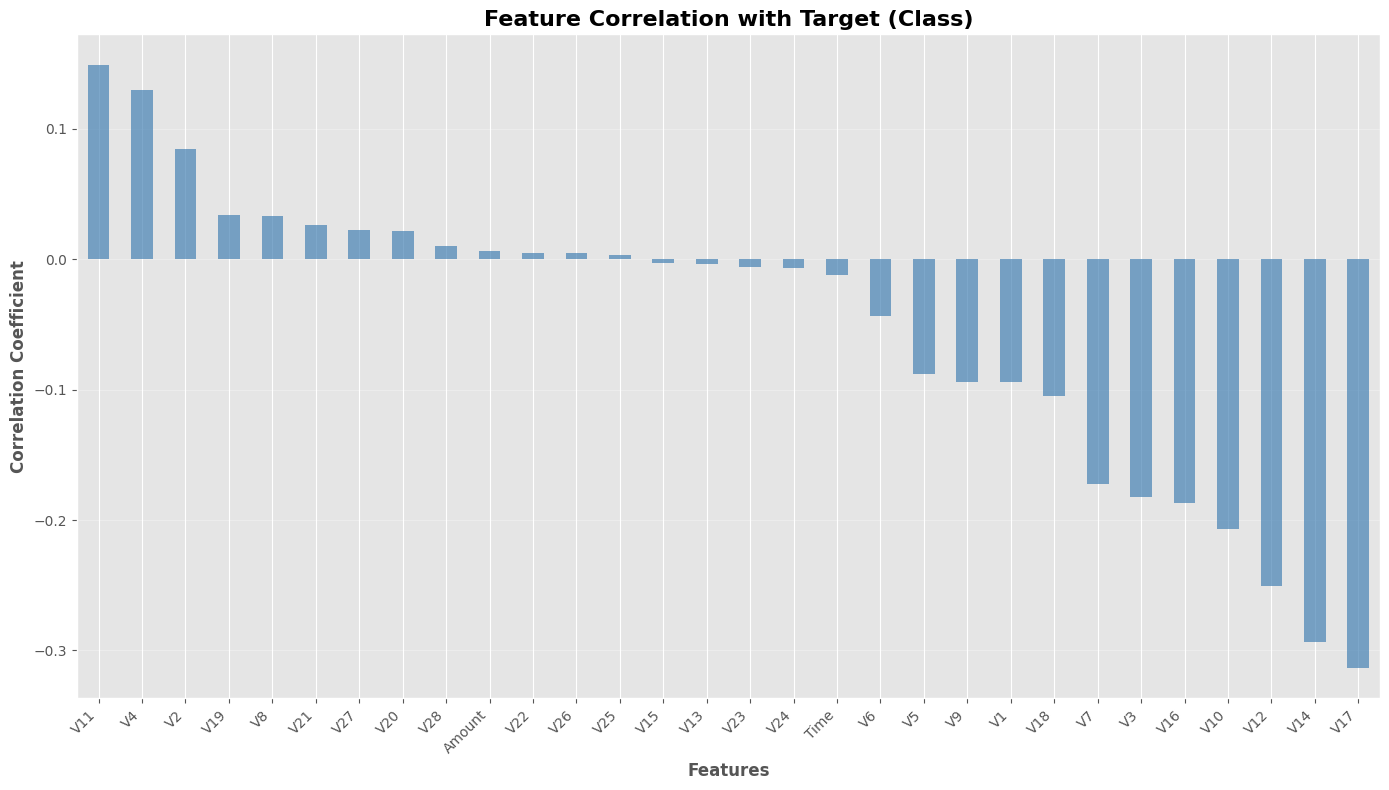

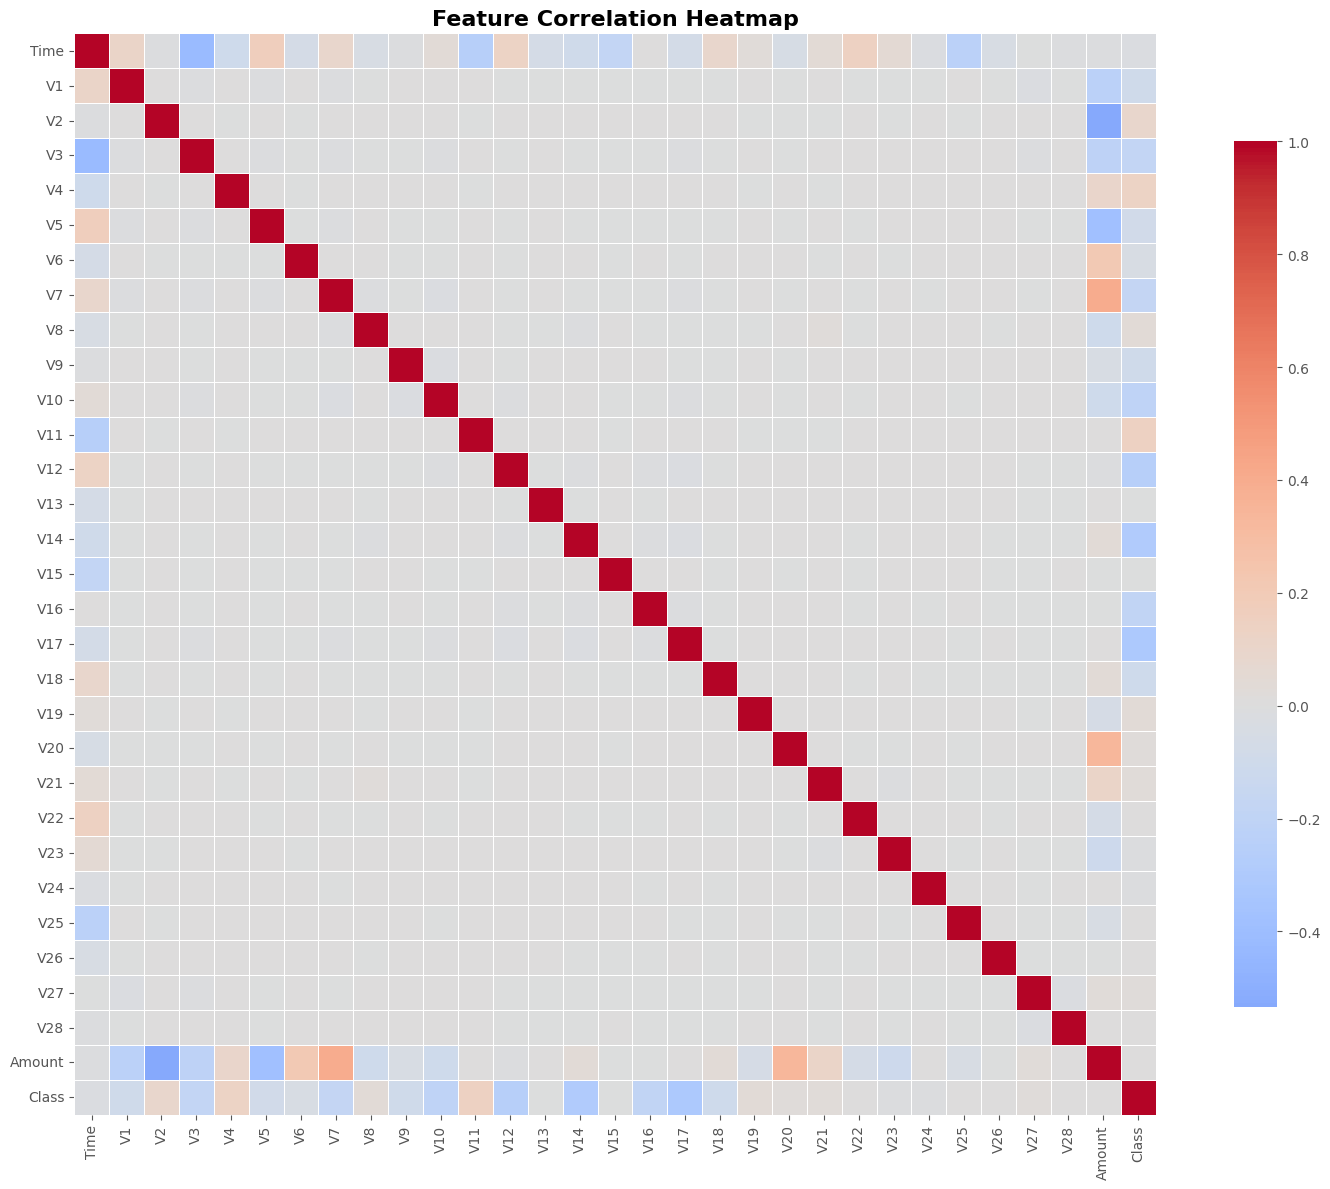

In [12]:
# ======================================================
# Correlation Analysis
# ======================================================

def analyse_correlations(df):
    """Analyse correlations between features and target"""
    print("\n7. CORRELATION ANALYSIS:")
    print("-" * 30)
    
    # Calculate correlation matrix
    correlation_matrix = df.corr()
    
    # Correlation with target
    target_correlation = correlation_matrix['Class'].drop('Class').sort_values(ascending=False)
    
    print("Top 10 features most correlated with target:")
    display(target_correlation.head(10))
    
    print("\nBottom 10 features least correlated with target:")
    display(target_correlation.tail(10))
    
    # Visualise correlation with target
    plt.figure(figsize=(14, 8))
    target_correlation.plot(kind='bar', color='steelblue', alpha=0.7)
    plt.title('Feature Correlation with Target (Class)', fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontweight='bold')
    plt.ylabel('Correlation Coefficient', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/target_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Heatmap of correlations
    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation_matrix, target_correlation

corr_matrix, target_corr = analyse_correlations(df)


8. AMOUNT AND TIME ANALYSIS BY CLASS:
----------------------------------------


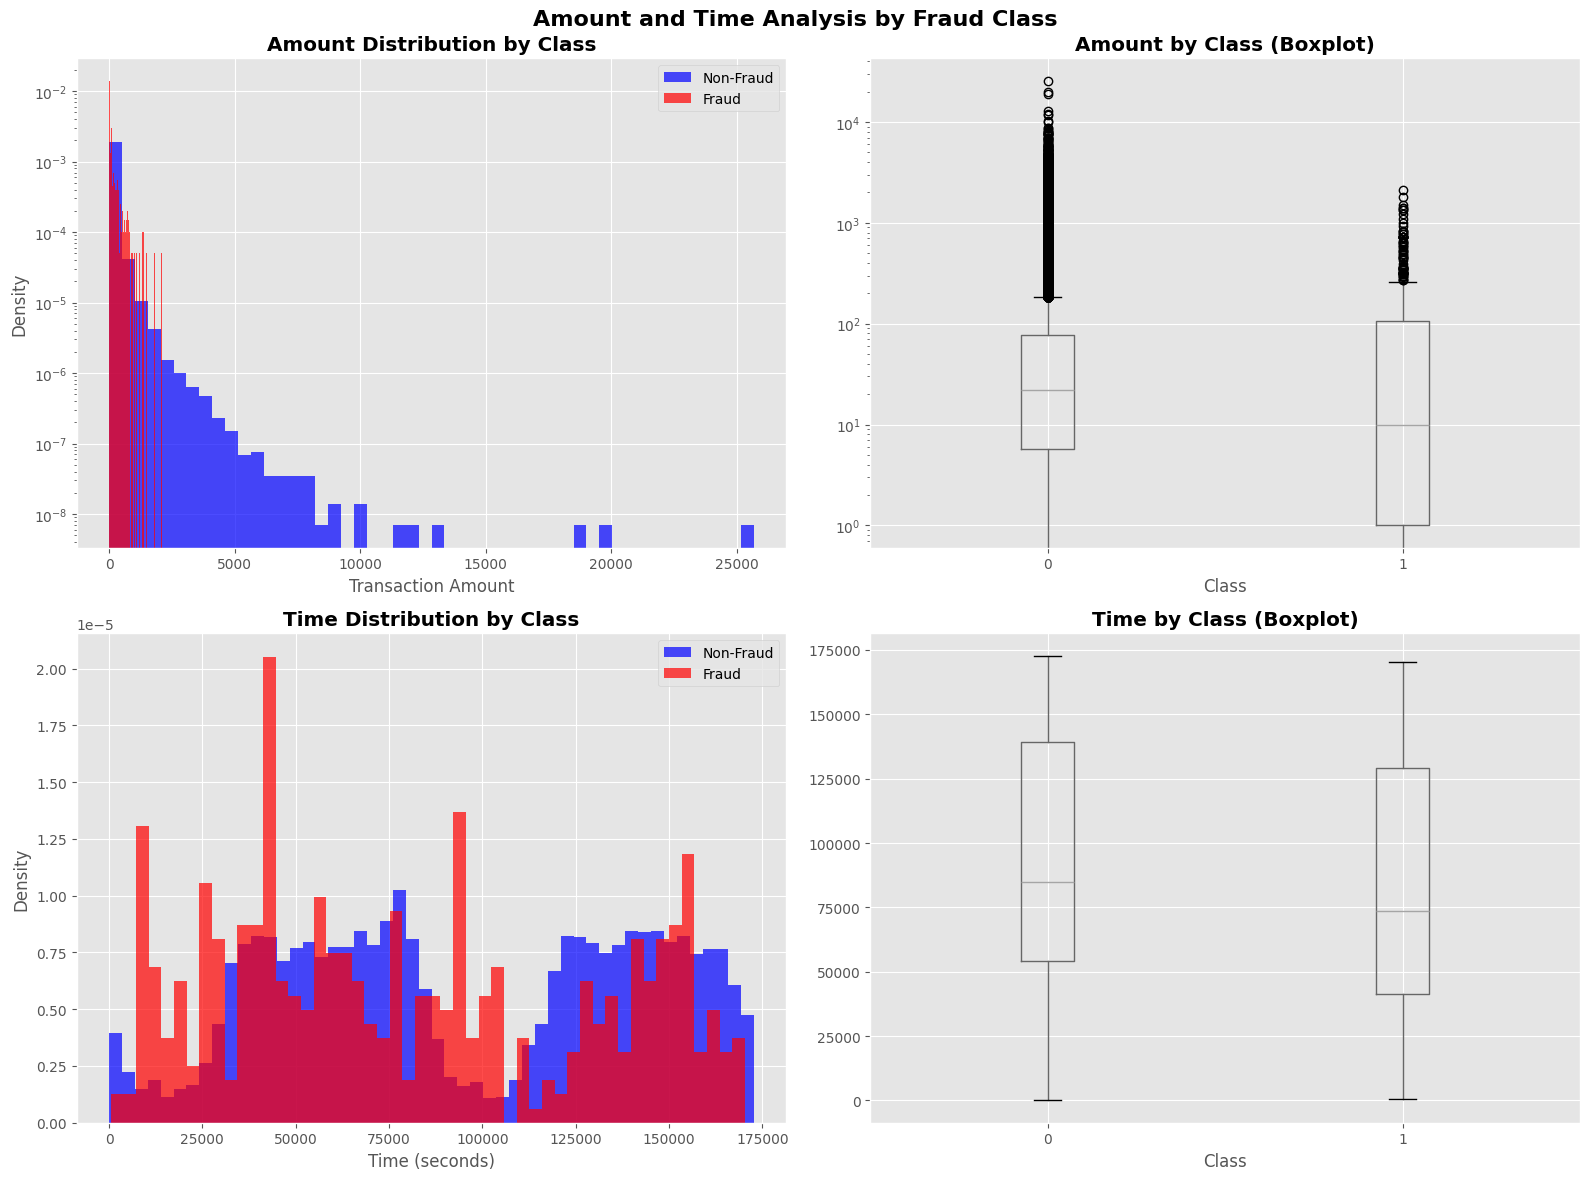

Amount Statistics by Class:
Non-Fraud - Mean: 88.41, Std: 250.38, Max: 25691.16
Fraud - Mean: 123.87, Std: 260.21, Max: 2125.87

Time Statistics by Class:
Non-Fraud - Mean: 94835.06, Std: 47475.55
Fraud - Mean: 80450.51, Std: 48636.18


In [13]:
# ======================================================
# Amount and Time Analysis by Class
# ======================================================

def analyse_amount_time_by_class(df):
    """Analyse Amount and Time features by class"""
    print("\n8. AMOUNT AND TIME ANALYSIS BY CLASS:")
    print("-" * 40)
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Amount distribution by class
    non_fraud_amount = df[df['Class'] == 0]['Amount']
    fraud_amount = df[df['Class'] == 1]['Amount']
    
    # Histograms
    ax1.hist(non_fraud_amount, bins=50, alpha=0.7, label='Non-Fraud', color='blue', density=True)
    ax1.hist(fraud_amount, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    ax1.set_title('Amount Distribution by Class', fontweight='bold')
    ax1.set_xlabel('Transaction Amount')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.set_yscale('log')
    
    # Boxplots
    df.boxplot(column='Amount', by='Class', ax=ax2)
    ax2.set_title('Amount by Class (Boxplot)', fontweight='bold')
    ax2.set_yscale('log')
    
    # Time distribution by class
    non_fraud_time = df[df['Class'] == 0]['Time']
    fraud_time = df[df['Class'] == 1]['Time']
    
    ax3.hist(non_fraud_time, bins=50, alpha=0.7, label='Non-Fraud', color='blue', density=True)
    ax3.hist(fraud_time, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    ax3.set_title('Time Distribution by Class', fontweight='bold')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Density')
    ax3.legend()
    
    df.boxplot(column='Time', by='Class', ax=ax4)
    ax4.set_title('Time by Class (Boxplot)', fontweight='bold')
    
    plt.suptitle('Amount and Time Analysis by Fraud Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('figures/amount_time_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical analysis
    print("Amount Statistics by Class:")
    print("Non-Fraud - Mean: {:.2f}, Std: {:.2f}, Max: {:.2f}".format(
        non_fraud_amount.mean(), non_fraud_amount.std(), non_fraud_amount.max()))
    print("Fraud - Mean: {:.2f}, Std: {:.2f}, Max: {:.2f}".format(
        fraud_amount.mean(), fraud_amount.std(), fraud_amount.max()))
    
    print("\nTime Statistics by Class:")
    print("Non-Fraud - Mean: {:.2f}, Std: {:.2f}".format(
        non_fraud_time.mean(), non_fraud_time.std()))
    print("Fraud - Mean: {:.2f}, Std: {:.2f}".format(
        fraud_time.mean(), fraud_time.std()))

analyse_amount_time_by_class(df)

In [14]:
# ======================================================
# Data Preprocessing
# ======================================================

def preprocess_data(df, test_size=0.2, val_size=0.2, random_state=42):
    """Preprocess the data for modelling"""
    print("\n" + "="*60)
    print("DATA PREPROCESSING")
    print("="*60)
    
    # Separate features and target
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    print(f"Original data shape: {X.shape}")
    print(f"Original class distribution: {Counter(y)}")
    
    # Split into train+val and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Split temp into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
    )
    
    print(f"\nAfter initial split:")
    print(f"Train shape: {X_train.shape}, Class dist: {Counter(y_train)}")
    print(f"Validation shape: {X_val.shape}, Class dist: {Counter(y_val)}")
    print(f"Test shape: {X_test.shape}, Class dist: {Counter(y_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df)


DATA PREPROCESSING
Original data shape: (283726, 30)
Original class distribution: Counter({0: 283253, 1: 473})

After initial split:
Train shape: (181584, 30), Class dist: Counter({0: 181282, 1: 302})
Validation shape: (45396, 30), Class dist: Counter({0: 45320, 1: 76})
Test shape: (56746, 30), Class dist: Counter({0: 56651, 1: 95})


In [15]:
# ======================================================
# Feature Scaling
# ======================================================

def scale_features(X_train, X_val, X_test, scaler_type='robust'):
    """Scale features using specified scaler"""
    print("\n9. FEATURE SCALING:")
    print("-" * 20)
    
    if scaler_type == 'robust':
        scaler = RobustScaler()
        print("Using RobustScaler (robust to outliers)")
    elif scaler_type == 'standard':
        scaler = StandardScaler()
        print("Using StandardScaler")
    else:
        raise ValueError("scaler_type must be 'robust' or 'standard'")
    
    # Fit on training data and transform all sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training data scaled shape: {X_train_scaled.shape}")
    print(f"Validation data scaled shape: {X_val_scaled.shape}")
    print(f"Test data scaled shape: {X_test_scaled.shape}")
    
    # Save the scaler for later use
    import joblib
    joblib.dump(scaler, 'saved_models/scaler.pkl')
    print("✓ Scaler saved to 'saved_models/scaler.pkl'")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Scale features
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_features(
    X_train, X_val, X_test, scaler_type='robust'
)


9. FEATURE SCALING:
--------------------
Using RobustScaler (robust to outliers)
Training data scaled shape: (181584, 30)
Validation data scaled shape: (45396, 30)
Test data scaled shape: (56746, 30)
✓ Scaler saved to 'saved_models/scaler.pkl'


In [16]:
# ======================================================
# Handle Class Imbalance
# ======================================================

def handle_class_imbalance(X_train, y_train, method='smote', random_state=42):
    """Handle class imbalance using specified method"""
    print("\n10. HANDLING CLASS IMBALANCE:")
    print("-" * 30)
    
    print(f"Original class distribution: {Counter(y_train)}")
    
    if method == 'smote':
        print("Using SMOTE (Synthetic Minority Over-sampling Technique)")
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
    elif method == 'undersample':
        print("Using Random UnderSampling")
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        
    elif method == 'none':
        print("No balancing technique applied")
        X_resampled, y_resampled = X_train, y_train
        
    else:
        raise ValueError("method must be 'smote', 'undersample', or 'none'")
    
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    print(f"Resampled data shape: {X_resampled.shape}")
    
    return X_resampled, y_resampled

# Handle class imbalance (choose one method)
X_train_balanced, y_train_balanced = handle_class_imbalance(
    X_train_scaled, y_train, method='smote'  # Change to 'undersample' or 'none' as needed
)


10. HANDLING CLASS IMBALANCE:
------------------------------
Original class distribution: Counter({0: 181282, 1: 302})
Using SMOTE (Synthetic Minority Over-sampling Technique)
Resampled class distribution: Counter({0: 181282, 1: 181282})
Resampled data shape: (362564, 30)


In [17]:
# ======================================================
# Prepare Data for Deep Learning
# ======================================================

def prepare_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=256):
    """Prepare PyTorch DataLoaders for deep learning"""
    print("\n11. PREPARING DATA FOR DEEP LEARNING:")
    print("-" * 40)
    
    import torch
    from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)
    
    print(f"Training tensor shapes: {X_train_tensor.shape}, {y_train_tensor.shape}")
    print(f"Validation tensor shapes: {X_val_tensor.shape}, {y_val_tensor.shape}")
    print(f"Test tensor shapes: {X_test_tensor.shape}, {y_test_tensor.shape}")
    
    # Create weighted sampler for imbalanced data (if not using SMOTE)
    if len(np.unique(y_train)) > 1 and np.bincount(y_train)[0] != np.bincount(y_train)[1]:
        class_counts = np.bincount(y_train)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        sample_weights = class_weights[y_train]
        
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        print("✓ WeightedRandomSampler created for imbalanced data")
    else:
        sampler = None
        print("✓ Using standard sampling (balanced data)")
    
    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             sampler=sampler, shuffle=sampler is None)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"✓ DataLoaders created with batch size: {batch_size}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Prepare data loaders
train_loader, val_loader, test_loader = prepare_dataloaders(
    X_train_balanced, y_train_balanced, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    batch_size=256
)


11. PREPARING DATA FOR DEEP LEARNING:
----------------------------------------
Training tensor shapes: torch.Size([362564, 30]), torch.Size([362564, 1])
Validation tensor shapes: torch.Size([45396, 30]), torch.Size([45396, 1])
Test tensor shapes: torch.Size([56746, 30]), torch.Size([56746, 1])
✓ Using standard sampling (balanced data)
✓ DataLoaders created with batch size: 256
Train batches: 1417
Validation batches: 178
Test batches: 222


In [18]:
# ======================================================
# Save Processed Data
# ======================================================

def save_processed_data(X_train, y_train, X_val, y_val, X_test, y_test):
    """Save processed data for future use"""
    print("\n12. SAVING PROCESSED DATA:")
    print("-" * 30)
    
    import joblib
    import numpy as np
    
    # Save as numpy arrays
    np.save('saved_artifacts/X_train.npy', X_train)
    np.save('saved_artifacts/y_train.npy', y_train)
    np.save('saved_artifacts/X_val.npy', X_val)
    np.save('saved_artifacts/y_val.npy', y_val)
    np.save('saved_artifacts/X_test.npy', X_test)
    np.save('saved_artifacts/y_test.npy', y_test)
    
    # Save as CSV for reference
    pd.DataFrame(X_train).to_csv('saved_artifacts/X_train.csv', index=False)
    pd.DataFrame(y_train).to_csv('saved_artifacts/y_train.csv', index=False)
    
    print("✓ Processed data saved to 'saved_artifacts/' directory")
    print("✓ Files include: X_train.npy, y_train.npy, X_val.npy, y_val.npy, X_test.npy, y_test.npy")

# Save processed data
save_processed_data(X_train_balanced, y_train_balanced, 
                   X_val_scaled, y_val, 
                   X_test_scaled, y_test)

print("\n" + "="*70)
print("STEP 2 COMPLETED SUCCESSFULLY!")
print("="*70)
print("✓ Comprehensive EDA performed")
print("✓ Data quality verified")
print("✓ Feature distributions analysed")
print("✓ Correlations examined")
print("✓ Data split into train/val/test sets")
print("✓ Features scaled using RobustScaler")
print("✓ Class imbalance handled with SMOTE")
print("✓ Data prepared for deep learning (PyTorch DataLoaders)")
print("✓ Processed data saved for future use")
print("✓ Ready for Step 3: Model Selection and Training")


12. SAVING PROCESSED DATA:
------------------------------
✓ Processed data saved to 'saved_artifacts/' directory
✓ Files include: X_train.npy, y_train.npy, X_val.npy, y_val.npy, X_test.npy, y_test.npy

STEP 2 COMPLETED SUCCESSFULLY!
✓ Comprehensive EDA performed
✓ Data quality verified
✓ Feature distributions analysed
✓ Correlations examined
✓ Data split into train/val/test sets
✓ Features scaled using RobustScaler
✓ Class imbalance handled with SMOTE
✓ Data prepared for deep learning (PyTorch DataLoaders)
✓ Processed data saved for future use
✓ Ready for Step 3: Model Selection and Training


### **Step 3: Model Selection**
In this step, we define three complementary deep learning models tailored to handle the extreme class imbalance (~0.17% fraud) and diverse fraud detection scenarios. Model 1: Multilayer Perceptron (MLP) serves as the supervised baseline, leveraging dense layers with Batch Normalisation and Dropout to capture complex non-linear patterns in transaction data for binary classification. Model 2: Autoencoder functions as an unsupervised anomaly detector, trained on normal transactions to learn their reconstruction patterns, with frauds identified when reconstruction errors exceed a threshold. Model 3: Variational Autoencoder (VAE) extends the autoencoder by modelling latent distributions with mean (µ) and variance (σ), enabling it to capture subtle, evolving fraud patterns probabilistically. Together, these three models supervised classification, anomaly detection, and probabilistic modeling—form a robust Three-Model Deep Learning Fraud Detection System designed to maximize detection accuracy and adaptability.

In [19]:
# ======================================================
# Step 3: Model Selection
# ======================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported for Model Selection")

✓ Libraries imported for Model Selection


In [20]:
# ======================================================
# Model 1: Multilayer Perceptron (MLP) - Supervised Classifier
# ======================================================

class MLP(nn.Module):
    """
    Multilayer Perceptron (MLP) for supervised fraud classification
    - Serves as baseline supervised model
    - Handles complex non-linear patterns
    - Uses BatchNorm and Dropout for regularisation
    """
    
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], dropout_rate=0.3):
        super(MLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        
        # Input layer
        layers = [
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        ]
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.extend([
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.BatchNorm1d(hidden_dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
        
        # Output layer
        layers.extend([
            nn.Linear(hidden_dims[-1], 1),
            nn.Sigmoid()
        ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    
    def get_config(self):
        """Return model configuration"""
        return {
            'model_type': 'MLP',
            'input_dim': self.input_dim,
            'hidden_dims': self.hidden_dims,
            'total_params': sum(p.numel() for p in self.parameters()),
            'trainable_params': sum(p.numel() for p in self.parameters() if p.requires_grad)
        }

# Create and display MLP model
input_dim = X_train_balanced.shape[1]
mlp_model = MLP(input_dim=input_dim)
print("Model 1: Multilayer Perceptron (MLP) - Supervised Classifier")
print("=" * 60)
print(mlp_model)
print(f"\nModel Configuration:")
config = mlp_model.get_config()
for key, value in config.items():
    print(f"  {key}: {value}")

# Display model architecture
print("\nModel Architecture Summary:")
print("-" * 30)
summary(mlp_model, (input_dim,))

Model 1: Multilayer Perceptron (MLP) - Supervised Classifier
MLP(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

Model Configuration:
  model_type: MLP
  input_dim: 30
  hidden_dims: [64, 32, 16]
  total_params: 4833
  trainable_params: 4833

Model Architecture Summary:
------------------------------
---------------------

In [21]:
# ======================================================
# Model 2: Autoencoder (AE) - Unsupervised Anomaly Detector
# ======================================================

class Autoencoder(nn.Module):
    """
    Autoencoder for unsupervised anomaly detection
    - Trained only on normal transactions
    - Learns to reconstruct normal patterns
    - Fraud detected when reconstruction error exceeds threshold
    """
    
    def __init__(self, input_dim, encoding_dim=8, hidden_dims=[32, 16]):
        super(Autoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_dims = hidden_dims
        
        # Encoder
        encoder_layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        encoder_layers.extend([
            nn.Linear(current_dim, encoding_dim),
            nn.ReLU()
        ])
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        current_dim = encoding_dim
        
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(current_dim, input_dim))
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Encode input to latent space"""
        return self.encoder(x)
    
    def decode(self, z):
        """Decode latent representation to original space"""
        return self.decoder(z)
    
    def reconstruct(self, x):
        """Reconstruct input and calculate error"""
        with torch.no_grad():
            reconstructed = self.forward(x)
            error = F.mse_loss(reconstructed, x, reduction='none').mean(dim=1)
        return reconstructed, error
    
    def get_config(self):
        """Return model configuration"""
        return {
            'model_type': 'Autoencoder',
            'input_dim': self.input_dim,
            'encoding_dim': self.encoding_dim,
            'hidden_dims': self.hidden_dims,
            'total_params': sum(p.numel() for p in self.parameters()),
            'trainable_params': sum(p.numel() for p in self.parameters() if p.requires_grad)
        }

# Create and display Autoencoder model
ae_model = Autoencoder(input_dim=input_dim)
print("\n" + "="*60)
print("Model 2: Autoencoder (AE) - Unsupervised Anomaly Detector")
print("=" * 60)
print(ae_model)
print(f"\nModel Configuration:")
config = ae_model.get_config()
for key, value in config.items():
    print(f"  {key}: {value}")

# Display model architecture
print("\nModel Architecture Summary:")
print("-" * 30)
summary(ae_model, (input_dim,))


Model 2: Autoencoder (AE) - Unsupervised Anomaly Detector
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=30, bias=True)
  )
)

Model Configuration:
  model_type: Autoencoder
  input_dim: 30
  encoding

In [22]:
# ======================================================
# Model 3: Variational Autoencoder (VAE) - Probabilistic Anomaly Detector
# ======================================================

class VAE(nn.Module):
    """
    Variational Autoencoder for probabilistic anomaly detection
    - Models latent distributions with mean (µ) and variance (σ)
    - Captures subtle, evolving fraud patterns probabilistically
    - Better generalisation to new fraud patterns
    """
    
    def __init__(self, input_dim, latent_dim=8, hidden_dims=[32, 16]):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        
        # Encoder
        encoder_layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(current_dim, latent_dim)
        self.fc_var = nn.Linear(current_dim, latent_dim)
        
        # Decoder
        decoder_layers = []
        current_dim = latent_dim
        
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(current_dim, input_dim))
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        """Encode input to latent distribution parameters"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        """Reparameterization trick for sampling"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent sample to original space"""
        return self.decoder(z)
    
    def forward(self, x):
        """Full forward pass"""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var
    
    def reconstruct(self, x):
        """Reconstruct input and calculate error"""
        with torch.no_grad():
            reconstructed, mu, log_var = self.forward(x)
            error = F.mse_loss(reconstructed, x, reduction='none').mean(dim=1)
        return reconstructed, error, mu, log_var
    
    def loss_function(self, reconstructed, x, mu, log_var, beta=1.0):
        """VAE loss: reconstruction + KL divergence"""
        reconstruction_loss = F.mse_loss(reconstructed, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return reconstruction_loss + beta * kl_divergence
    
    def get_config(self):
        """Return model configuration"""
        return {
            'model_type': 'Variational Autoencoder',
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim,
            'hidden_dims': self.hidden_dims,
            'total_params': sum(p.numel() for p in self.parameters()),
            'trainable_params': sum(p.numel() for p in self.parameters() if p.requires_grad)
        }

# Create and display VAE model
vae_model = VAE(input_dim=input_dim)
print("\n" + "="*60)
print("Model 3: Variational Autoencoder (VAE) - Probabilistic Anomaly Detector")
print("=" * 60)
print(vae_model)
print(f"\nModel Configuration:")
config = vae_model.get_config()
for key, value in config.items():
    print(f"  {key}: {value}")

# Display model architecture
print("\nModel Architecture Summary:")
print("-" * 30)
summary(vae_model, (input_dim,))


Model 3: Variational Autoencoder (VAE) - Probabilistic Anomaly Detector
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=16, out_features=8, bias=True)
  (fc_var): Linear(in_features=16, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=30, bias=True)
  )
)

Model Configuration

In [23]:
# ======================================================
# Three-Model Ensemble System
# ======================================================

class FraudDetectionEnsemble(nn.Module):
    """
    Three-Model Ensemble System for comprehensive fraud detection
    Combines:
    1. MLP: Supervised classification
    2. Autoencoder: Unsupervised anomaly detection  
    3. VAE: Probabilistic anomaly detection
    """
    
    def __init__(self, mlp_model, ae_model, vae_model):
        super(FraudDetectionEnsemble, self).__init__()
        
        self.mlp = mlp_model
        self.ae = ae_model
        self.vae = vae_model
        
        # Freeze models (they will be trained separately)
        for param in self.mlp.parameters():
            param.requires_grad = False
        for param in self.ae.parameters():
            param.requires_grad = False
        for param in self.vae.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        """Get predictions from all three models"""
        # MLP prediction (supervised)
        mlp_pred = self.mlp(x)
        
        # Autoencoder reconstruction error
        ae_reconstructed = self.ae(x)
        ae_error = F.mse_loss(ae_reconstructed, x, reduction='none').mean(dim=1, keepdim=True)
        
        # VAE reconstruction error
        vae_reconstructed, mu, log_var = self.vae(x)
        vae_error = F.mse_loss(vae_reconstructed, x, reduction='none').mean(dim=1, keepdim=True)
        
        return mlp_pred, ae_error, vae_error
    
    def predict(self, x, ae_threshold=None, vae_threshold=None, mlp_threshold=0.5):
        """
        Make ensemble prediction
        Returns: MLP prediction, AE anomaly score, VAE anomaly score, ensemble prediction
        """
        with torch.no_grad():
            mlp_pred, ae_error, vae_error = self.forward(x)
            
            # Convert to binary predictions
            mlp_binary = (mlp_pred > mlp_threshold).float()
            
            if ae_threshold is not None:
                ae_binary = (ae_error > ae_threshold).float()
            else:
                ae_binary = None
                
            if vae_threshold is not None:
                vae_binary = (vae_error > vae_threshold).float()
            else:
                vae_binary = None
                
            # Ensemble prediction (majority vote if thresholds are provided)
            if ae_binary is not None and vae_binary is not None:
                ensemble_pred = (mlp_binary + ae_binary + vae_binary) >= 2
            else:
                ensemble_pred = mlp_binary
                
            return {
                'mlp_prediction': mlp_pred,
                'ae_error': ae_error,
                'vae_error': vae_error,
                'mlp_binary': mlp_binary,
                'ae_binary': ae_binary,
                'vae_binary': vae_binary,
                'ensemble_pred': ensemble_pred
            }
    
    def get_config(self):
        """Return ensemble configuration"""
        return {
            'ensemble_type': 'Three-Model Fraud Detection System',
            'mlp_config': self.mlp.get_config(),
            'ae_config': self.ae.get_config(),
            'vae_config': self.vae.get_config(),
            'total_params': sum(p.numel() for p in self.parameters()),
            'description': 'Combines supervised classification (MLP) with unsupervised anomaly detection (AE, VAE)'
        }

# Create the ensemble system
ensemble_system = FraudDetectionEnsemble(mlp_model, ae_model, vae_model)
print("\n" + "="*70)
print("Three-Model Ensemble Fraud Detection System")
print("=" * 70)
print(ensemble_system)
print(f"\nEnsemble Configuration:")
config = ensemble_system.get_config()
for key, value in config.items():
    if key != 'mlp_config' and key != 'ae_config' and key != 'vae_config':
        print(f"  {key}: {value}")

print(f"\nTotal parameters in ensemble: {config['total_params']:,}")


Three-Model Ensemble Fraud Detection System
FraudDetectionEnsemble(
  (mlp): MLP(
    (model): Sequential(
      (0): Linear(in_features=30, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.3, inplace=False)
      (8): Linear(in_features=32, out_features=16, bias=True)
      (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.3, inplace=False)
      (12): Linear(in_features=16, out_features=1, bias=True)
      (13): Sigmoid()
    )
  )
  (ae): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=30, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1

MODEL COMPARISON AND ANALYSIS
Model Architecture Comparison:
----------------------------------------


,Model,Type,Total Params,Trainable Params,Input Dim,Latent/Encoding Dim,Hidden Layers
0,MLP,MLP,"4,833",0,30,N/A,"[64, 32, 16]"
1,Autoencoder,Autoencoder,"3,526",0,30,8,"[32, 16]"
2,Variational Autoencoder,Variational Autoencoder,"3,662",0,30,8,"[32, 16]"


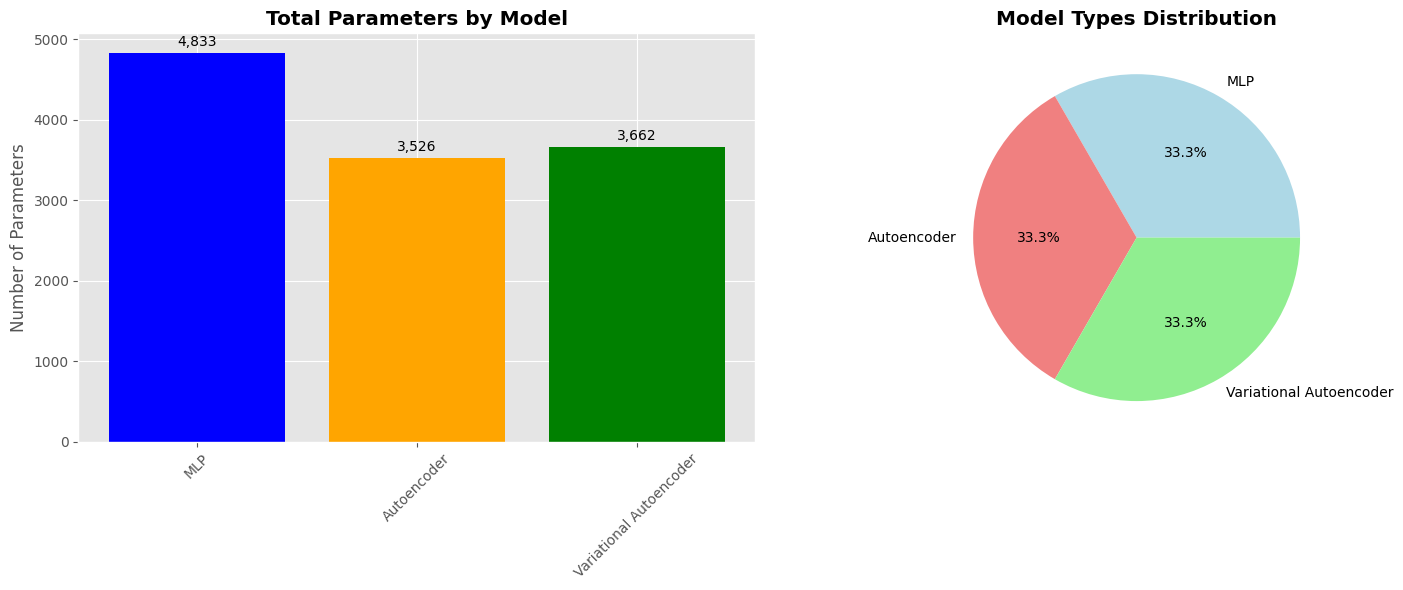

In [24]:
# ======================================================
# Model Comparison and Analysis
# ======================================================

def compare_models(models_dict):
    """Compare the three models based on architecture and parameters"""
    print("="*60)
    print("MODEL COMPARISON AND ANALYSIS")
    print("="*60)
    
    comparison_data = []
    
    for name, model in models_dict.items():
        if hasattr(model, 'get_config'):
            config = model.get_config()
            comparison_data.append({
                'Model': name,
                'Type': config.get('model_type', 'N/A'),
                'Total Params': f"{config.get('total_params', 0):,}",
                'Trainable Params': f"{config.get('trainable_params', 0):,}",
                'Input Dim': config.get('input_dim', 'N/A'),
                'Latent/Encoding Dim': config.get('latent_dim', config.get('encoding_dim', 'N/A')),
                'Hidden Layers': str(config.get('hidden_dims', 'N/A'))
            })
    
    # Create comparison table
    comparison_df = pd.DataFrame(comparison_data)
    print("Model Architecture Comparison:")
    print("-" * 40)
    display(comparison_df)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Parameter comparison
    params = [int(x['Total Params'].replace(',', '')) for x in comparison_data]
    ax1.bar([x['Model'] for x in comparison_data], params, color=['blue', 'orange', 'green'])
    ax1.set_title('Total Parameters by Model', fontweight='bold')
    ax1.set_ylabel('Number of Parameters')
    ax1.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(params):
        ax1.text(i, v + max(params)*0.01, f'{v:,}', ha='center', va='bottom')
    
    # Model type visualization
    model_types = [x['Type'] for x in comparison_data]
    ax2.pie([1, 1, 1], labels=model_types, autopct='%1.1f%%', 
            colors=['lightblue', 'lightcoral', 'lightgreen'])
    ax2.set_title('Model Types Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comparison_df

# Compare the three models
models_dict = {
    'MLP': mlp_model,
    'Autoencoder': ae_model,
    'Variational Autoencoder': vae_model
}

model_comparison = compare_models(models_dict)

In [25]:
# ======================================================
# Model Training Strategy
# ======================================================

def define_training_strategy():
    """Define the training strategy for each model"""
    print("\n" + "="*60)
    print("MODEL TRAINING STRATEGY")
    print("="*60)
    
    strategy = {
        'MLP': {
            'type': 'Supervised',
            'loss': 'Binary Cross-Entropy',
            'optimizer': 'Adam',
            'learning_rate': 0.001,
            'batch_size': 256,
            'epochs': 50,
            'regularisation': 'Dropout + BatchNorm',
            'data': 'Balanced training set (SMOTE)',
            'validation': 'Standard validation set',
            'purpose': 'Baseline classification of fraudulent transactions'
        },
        'Autoencoder': {
            'type': 'Unsupervised',
            'loss': 'Mean Squared Error (Reconstruction)',
            'optimizer': 'Adam',
            'learning_rate': 0.001,
            'batch_size': 256,
            'epochs': 50,
            'regularisation': 'BatchNorm',
            'data': 'Normal transactions only (Class 0)',
            'validation': 'Both normal and fraudulent transactions',
            'purpose': 'Anomaly detection via reconstruction error',
            'threshold': 'Optimised based on validation performance'
        },
        'Variational Autoencoder': {
            'type': 'Unsupervised (Probabilistic)',
            'loss': 'MSE Reconstruction + KL Divergence',
            'optimizer': 'Adam',
            'learning_rate': 0.001,
            'batch_size': 256,
            'epochs': 50,
            'regularisation': 'BatchNorm + KL weighting',
            'data': 'Normal transactions only (Class 0)',
            'validation': 'Both normal and fraudulent transactions',
            'purpose': 'Probabilistic anomaly detection',
            'threshold': 'Optimised based on validation performance',
            'beta': 'KL weight parameter (tunable)'
        }
    }
    
    # Display training strategy
    strategy_df = pd.DataFrame(strategy).T
    print("Training Strategy for Each Model:")
    print("-" * 40)
    display(strategy_df)
    
    # Save strategy to file
    strategy_df.to_csv('saved_artifacts/training_strategy.csv')
    print("✓ Training strategy saved to 'saved_artifacts/training_strategy.csv'")
    
    return strategy

# Define training strategy
training_strategy = define_training_strategy()


MODEL TRAINING STRATEGY
Training Strategy for Each Model:
----------------------------------------


,type,loss,optimizer,learning_rate,batch_size,epochs,regularisation,data,validation,purpose,threshold,beta
MLP,Supervised,Binary Cross-Entropy,Adam,0.001,256,50,Dropout + BatchNorm,Balanced training set (SMOTE),Standard validation set,Baseline classification of fraudulent transact...,NaN,NaN
Autoencoder,Unsupervised,Mean Squared Error (Reconstruction),Adam,0.001,256,50,BatchNorm,Normal transactions only (Class 0),Both normal and fraudulent transactions,Anomaly detection via reconstruction error,Optimised based on validation performance,NaN
Variational Autoencoder,Unsupervised (Probabilistic),MSE Reconstruction + KL Divergence,Adam,0.001,256,50,BatchNorm + KL weighting,Normal transactions only (Class 0),Both normal and fraudulent transactions,Probabilistic anomaly detection,Optimised based on validation performance,KL weight parameter (tunable)


✓ Training strategy saved to 'saved_artifacts/training_strategy.csv'


In [26]:
# ======================================================
# Save Model Architectures
# ======================================================

def save_model_architectures(models_dict):
    """Save model architectures for future reference"""
    print("\nSaving model architectures...")
    
    import json
    from datetime import datetime
    
    # Create model info dictionary
    model_info = {
        'timestamp': datetime.now().isoformat(),
        'input_dimension': input_dim,
        'models': {}
    }
    
    for name, model in models_dict.items():
        if hasattr(model, 'get_config'):
            model_info['models'][name] = model.get_config()
    
    # Save to JSON file
    with open('saved_artifacts/model_architectures.json', 'w') as f:
        json.dump(model_info, f, indent=2)
    
    print("✓ Model architectures saved to 'saved_artifacts/model_architectures.json'")
    
    # Save model state dicts (empty weights)
    torch.save(mlp_model.state_dict(), 'saved_models/mlp_model.pth')
    torch.save(ae_model.state_dict(), 'saved_models/autoencoder_model.pth')
    torch.save(vae_model.state_dict(), 'saved_models/vae_model.pth')
    
    print("✓ Model state dictionaries saved to 'saved_models/' directory")
    
    return model_info

# Save model architectures
model_info = save_model_architectures(models_dict)

print("\n" + "="*70)
print("STEP 3 COMPLETED SUCCESSFULLY!")
print("="*70)
print("✓ Three complementary deep learning models defined:")
print("  1. MLP: Supervised classification baseline")
print("  2. Autoencoder: Unsupervised anomaly detection")  
print("  3. VAE: Probabilistic anomaly detection")
print("✓ Model architectures analysed and compared")
print("✓ Training strategy defined for each model")
print("✓ Ensemble system created for combined predictions")
print("✓ Model configurations saved for reference")
print("✓ Ready for Step 4: Model Training and Evaluation")


Saving model architectures...
✓ Model architectures saved to 'saved_artifacts/model_architectures.json'
✓ Model state dictionaries saved to 'saved_models/' directory

STEP 3 COMPLETED SUCCESSFULLY!
✓ Three complementary deep learning models defined:
  1. MLP: Supervised classification baseline
  2. Autoencoder: Unsupervised anomaly detection
  3. VAE: Probabilistic anomaly detection
✓ Model architectures analysed and compared
✓ Training strategy defined for each model
✓ Ensemble system created for combined predictions
✓ Model configurations saved for reference
✓ Ready for Step 4: Model Training and Evaluation


### **Step 4: Model Training and Evaluation Code**
In this step, three deep learning models MLP, Autoencoder (AE), and Variational Autoencoder (VAE) are trained and evaluated for fraud detection. The MLP is trained in a supervised manner on all labeled transactions to classify fraud directly, while the AE and VAE are trained only on normal transactions to detect anomalies through reconstruction errors, with thresholds set from the training data. After training, all models are evaluated on the test set using Accuracy, Precision, Recall, F1 Score, and ROC AUC, and AE/VAE performance is further assessed based on anomaly detection above their thresholds. Finally, all models (mlp_model, autoencoder_model, vae_model), along with the scaler and AE/VAE thresholds, are saved to disk to ensure they can be loaded later for deployment.

In [27]:
# ======================================================
# Step 4: Model Training and Evaluation
# ======================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, precision_recall_curve)
import joblib
import time
import json
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported for Model Training and Evaluation")

Libraries imported for Model Training and Evaluation


In [28]:
# ======================================================
# Load Preprocessed Data
# ======================================================

def load_preprocessed_data():
    """Load the preprocessed data from Step 2"""
    print("Loading preprocessed data...")
    
    try:
        # Load numpy arrays
        X_train = np.load('saved_artifacts/X_train.npy')
        y_train = np.load('saved_artifacts/y_train.npy')
        X_val = np.load('saved_artifacts/X_val.npy')
        y_val = np.load('saved_artifacts/y_val.npy')
        X_test = np.load('saved_artifacts/X_test.npy')
        y_test = np.load('saved_artifacts/y_test.npy')
        
        print("Preprocessed data loaded successfully!")
        print(f"Train shape: {X_train.shape}, {y_train.shape}")
        print(f"Validation shape: {X_val.shape}, {y_val.shape}")
        print(f"Test shape: {X_test.shape}, {y_test.shape}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test
        
    except Exception as e:
        print(f"✗ Error loading preprocessed data: {e}")
        raise

# Load the data
X_train, y_train, X_val, y_val, X_test, y_test = load_preprocessed_data()

Loading preprocessed data...
Preprocessed data loaded successfully!
Train shape: (362564, 30), (362564,)
Validation shape: (45396, 30), (45396,)
Test shape: (56746, 30), (56746,)


In [29]:
# ======================================================
# Prepare DataLoaders
# ======================================================

def prepare_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=256):
    """Prepare PyTorch DataLoaders for training"""
    print("\nPreparing DataLoaders...")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"DataLoaders created with batch size: {batch_size}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Prepare DataLoaders
train_loader, val_loader, test_loader = prepare_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, batch_size=256
)


Preparing DataLoaders...
DataLoaders created with batch size: 256
Train batches: 1417
Validation batches: 178
Test batches: 222


In [30]:
# ======================================================
# Model Definitions (Recreate from Step 3)
# ======================================================

class MLP(nn.Module):
    """Multilayer Perceptron for supervised fraud classification"""
    
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], dropout_rate=0.3):
        super(MLP, self).__init__()
        
        layers = [
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.BatchNorm1d(hidden_dims[2]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dims[2], 1),
            nn.Sigmoid()
        ]
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

class Autoencoder(nn.Module):
    """Autoencoder for unsupervised anomaly detection"""
    
    def __init__(self, input_dim, encoding_dim=8, hidden_dims=[32, 16]):
        super(Autoencoder, self).__init__()
        
        # Encoder
        encoder_layers = [
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            
            nn.Linear(hidden_dims[1], encoding_dim),
            nn.ReLU()
        ]
        
        # Decoder
        decoder_layers = [
            nn.Linear(encoding_dim, hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            
            nn.Linear(hidden_dims[0], input_dim)
        ]
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def reconstruct(self, x):
        """Reconstruct input and calculate error"""
        with torch.no_grad():
            reconstructed = self.forward(x)
            error = nn.functional.mse_loss(reconstructed, x, reduction='none').mean(dim=1)
        return reconstructed, error

class VAE(nn.Module):
    """Variational Autoencoder for probabilistic anomaly detection"""
    
    def __init__(self, input_dim, latent_dim=8, hidden_dims=[32, 16]):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU()
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[1], latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            
            nn.Linear(hidden_dims[0], input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var
    
    def reconstruct(self, x):
        """Reconstruct input and calculate error"""
        with torch.no_grad():
            reconstructed, mu, log_var = self.forward(x)
            error = nn.functional.mse_loss(reconstructed, x, reduction='none').mean(dim=1)
        return reconstructed, error, mu, log_var
    
    def loss_function(self, reconstructed, x, mu, log_var, beta=1.0):
        reconstruction_loss = nn.functional.mse_loss(reconstructed, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return reconstruction_loss + beta * kl_divergence

# Create model instances
input_dim = X_train.shape[1]
mlp_model = MLP(input_dim=input_dim)
ae_model = Autoencoder(input_dim=input_dim)
vae_model = VAE(input_dim=input_dim)

print("Models created successfully!")
print(f"MLP parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")
print(f"Autoencoder parameters: {sum(p.numel() for p in ae_model.parameters()):,}")
print(f"VAE parameters: {sum(p.numel() for p in vae_model.parameters()):,}")

Models created successfully!
MLP parameters: 4,833
Autoencoder parameters: 3,526
VAE parameters: 3,662


In [31]:
# ======================================================
# Training Utilities
# ======================================================

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def plot_training_history(train_losses, val_losses, val_metrics, model_name):
    """Plot training history and metrics"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Training and validation loss
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title(f'{model_name} - Training History', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Validation metrics
    epochs = range(1, len(val_metrics) + 1)
    ax2.plot(epochs, [m['accuracy'] for m in val_metrics], label='Accuracy', color='green')
    ax2.plot(epochs, [m['precision'] for m in val_metrics], label='Precision', color='blue')
    ax2.plot(epochs, [m['recall'] for m in val_metrics], label='Recall', color='red')
    ax2.plot(epochs, [m['f1'] for m in val_metrics], label='F1 Score', color='purple')
    ax2.set_title(f'{model_name} - Validation Metrics', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ROC AUC
    if 'roc_auc' in val_metrics[0]:
        ax3.plot(epochs, [m['roc_auc'] for m in val_metrics], label='ROC AUC', color='orange')
        ax3.set_title(f'{model_name} - ROC AUC', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('ROC AUC')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Precision-Recall
    ax4.plot(epochs, [m['precision'] for m in val_metrics], label='Precision', color='blue')
    ax4.plot(epochs, [m['recall'] for m in val_metrics], label='Recall', color='red')
    ax4.set_title(f'{model_name} - Precision vs Recall', fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/{model_name.lower()}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def calculate_metrics(y_true, y_pred, y_prob=None):
    """Calculate evaluation metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    if y_prob is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    
    return metrics


Training MLP Model (Supervised)
Epoch [1/50]
  Train Loss: 0.1162, Val Loss: 0.0262
  Accuracy: 0.9899, Precision: 0.1315
  Recall: 0.8947, F1: 0.2293, ROC AUC: 0.9680
Epoch [5/50]
  Train Loss: 0.0196, Val Loss: 0.0161
  Accuracy: 0.9949, Precision: 0.2310
  Recall: 0.8816, F1: 0.3661, ROC AUC: 0.9696
Epoch [10/50]
  Train Loss: 0.0126, Val Loss: 0.0080
  Accuracy: 0.9982, Precision: 0.4853
  Recall: 0.8684, F1: 0.6226, ROC AUC: 0.9750
Epoch [15/50]
  Train Loss: 0.0118, Val Loss: 0.0056
  Accuracy: 0.9992, Precision: 0.7174
  Recall: 0.8684, F1: 0.7857, ROC AUC: 0.9737
Epoch [20/50]
  Train Loss: 0.0102, Val Loss: 0.0065
  Accuracy: 0.9989, Precision: 0.6275
  Recall: 0.8421, F1: 0.7191, ROC AUC: 0.9755
Epoch [25/50]
  Train Loss: 0.0083, Val Loss: 0.0060
  Accuracy: 0.9992, Precision: 0.7065
  Recall: 0.8553, F1: 0.7738, ROC AUC: 0.9774
Early stopping triggered at epoch 25

✓ MLP training completed in 516.40 seconds


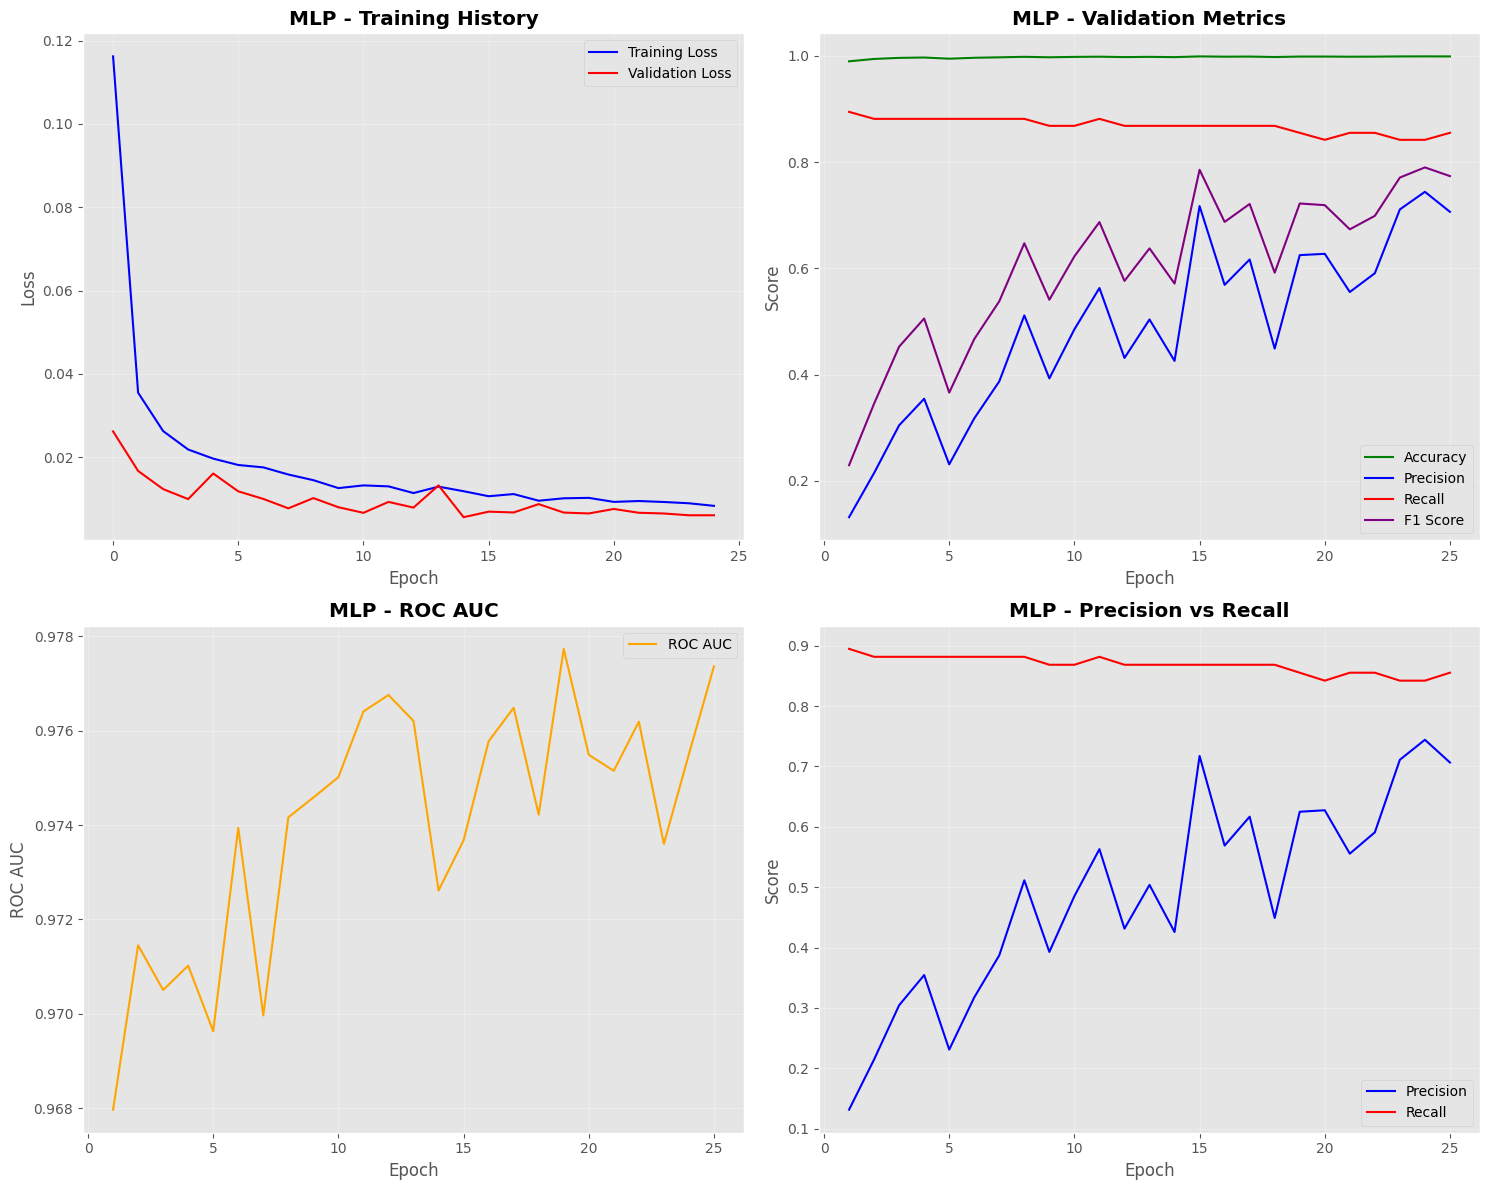

In [32]:
# ======================================================
# Model 1: MLP Training
# ======================================================

def train_mlp(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Train the MLP model"""
    print("\n" + "="*60)
    print("Training MLP Model (Supervised)")
    print("="*60)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    
    train_losses = []
    val_losses = []
    val_metrics_history = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_probs = []
        all_true = []
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                preds = (outputs > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
                all_true.extend(batch_y.cpu().numpy())
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        metrics = calculate_metrics(np.array(all_true).flatten(), 
                                   np.array(all_preds).flatten(),
                                   np.array(all_probs).flatten())
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_metrics_history.append(metrics)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'  Accuracy: {metrics["accuracy"]:.4f}, Precision: {metrics["precision"]:.4f}')
            print(f'  Recall: {metrics["recall"]:.4f}, F1: {metrics["f1"]:.4f}, ROC AUC: {metrics["roc_auc"]:.4f}')
        
        # Early stopping check
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    training_time = time.time() - start_time
    print(f"\n✓ MLP training completed in {training_time:.2f} seconds")
    
    # Plot training history
    plot_training_history(train_losses, val_losses, val_metrics_history, 'MLP')
    
    return model, train_losses, val_losses, val_metrics_history

# Train MLP
mlp_model, mlp_train_losses, mlp_val_losses, mlp_val_metrics = train_mlp(
    mlp_model, train_loader, val_loader, num_epochs=50, learning_rate=0.001
)


Training Autoencoder Model (Unsupervised)
Epoch [1/50]
  Train Loss: 1.066781, Val Loss: 0.623793
Epoch [10/50]
  Train Loss: 0.444622, Val Loss: 0.409824
Epoch [20/50]
  Train Loss: 0.385245, Val Loss: 0.375032
Epoch [30/50]
  Train Loss: 0.352153, Val Loss: 0.368698
Epoch [40/50]
  Train Loss: 0.336482, Val Loss: 0.328797
Epoch [50/50]
  Train Loss: 0.323280, Val Loss: 0.313324

✓ Autoencoder training completed in 812.14 seconds


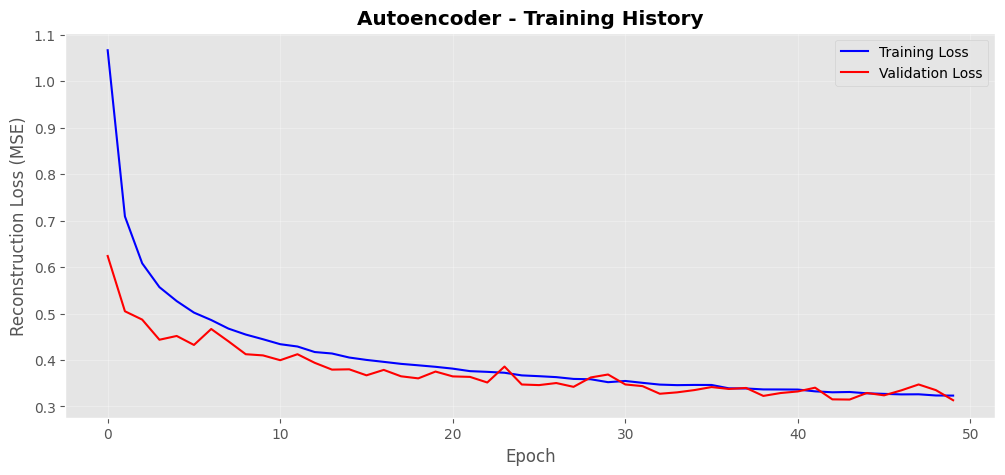

In [33]:
# ======================================================
# Model 2: Autoencoder Training
# ======================================================

def train_autoencoder(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Train the Autoencoder model on normal transactions only"""
    print("\n" + "="*60)
    print("Training Autoencoder Model (Unsupervised)")
    print("="*60)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=15, min_delta=0.0001)
    
    train_losses = []
    val_losses = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase (only on normal transactions)
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            # Use only normal transactions for training
            normal_mask = (batch_y == 0).flatten()
            if normal_mask.sum() > 0:
                normal_batch = batch_x[normal_mask]
                normal_batch = normal_batch.to(device)
                
                optimizer.zero_grad()
                reconstructed = model(normal_batch)
                loss = criterion(reconstructed, normal_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
        
        # Validation phase (on all transactions)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                reconstructed = model(batch_x)
                loss = criterion(reconstructed, batch_x)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        
        # Early stopping check
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    training_time = time.time() - start_time
    print(f"\n✓ Autoencoder training completed in {training_time:.2f} seconds")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Autoencoder - Training History', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('figures/autoencoder_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, train_losses, val_losses

# Train Autoencoder
ae_model, ae_train_losses, ae_val_losses = train_autoencoder(
    ae_model, train_loader, val_loader, num_epochs=50, learning_rate=0.001
)


Training Variational Autoencoder Model (Unsupervised)
Epoch [1/100]
  Train Loss: 5149.272627, Val Loss: 7290.437209
Epoch [10/100]
  Train Loss: 3084.174697, Val Loss: 5881.504938
Epoch [20/100]
  Train Loss: 2883.225344, Val Loss: 5701.995221
Epoch [30/100]
  Train Loss: 2794.023655, Val Loss: 5666.091543
Epoch [40/100]
  Train Loss: 2723.629187, Val Loss: 5434.816347
Epoch [50/100]
  Train Loss: 2685.810426, Val Loss: 5377.581014
Epoch [60/100]
  Train Loss: 2670.873484, Val Loss: 5398.030305
Epoch [70/100]
  Train Loss: 2638.420353, Val Loss: 5278.390173
Epoch [80/100]
  Train Loss: 2629.992011, Val Loss: 5298.472398
Epoch [90/100]
  Train Loss: 2620.995998, Val Loss: 5358.043852
Epoch [100/100]
  Train Loss: 2598.733126, Val Loss: 5273.144242

✓ VAE training completed in 1413.82 seconds


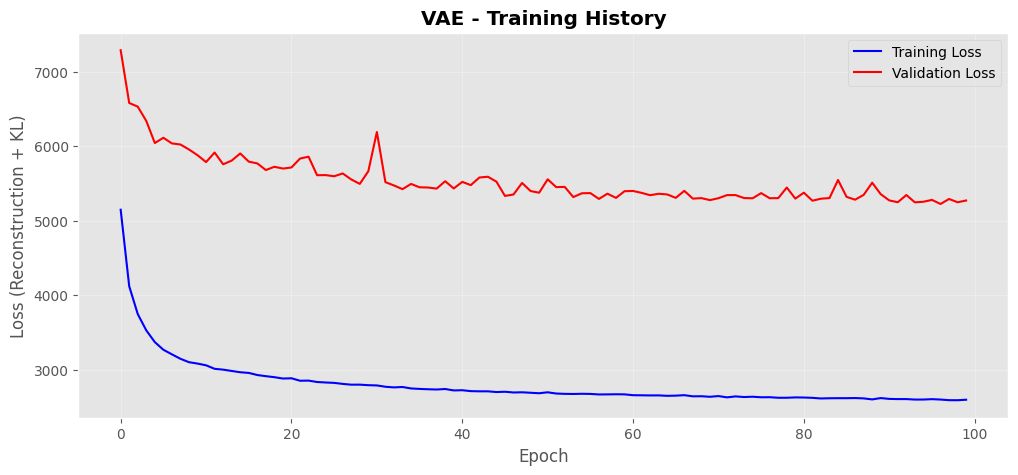

In [34]:
# ======================================================
# Model 3: VAE Training
# ======================================================

def train_vae(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, beta=1.0):
    """Train the Variational Autoencoder model on normal transactions only"""
    print("\n" + "="*60)
    print("Training Variational Autoencoder Model (Unsupervised)")
    print("="*60)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=15, min_delta=0.0001)
    
    train_losses = []
    val_losses = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase (only on normal transactions)
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            # Use only normal transactions for training
            normal_mask = (batch_y == 0).flatten()
            if normal_mask.sum() > 0:
                normal_batch = batch_x[normal_mask]
                normal_batch = normal_batch.to(device)
                
                optimizer.zero_grad()
                reconstructed, mu, log_var = model(normal_batch)
                loss = model.loss_function(reconstructed, normal_batch, mu, log_var, beta=beta)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
        
        # Validation phase (on all transactions)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                reconstructed, mu, log_var = model(batch_x)
                loss = model.loss_function(reconstructed, batch_x, mu, log_var, beta=beta)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        
        # Early stopping check
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    training_time = time.time() - start_time
    print(f"\n✓ VAE training completed in {training_time:.2f} seconds")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('VAE - Training History', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Reconstruction + KL)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('figures/vae_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, train_losses, val_losses

# Train VAE
vae_model, vae_train_losses, vae_val_losses = train_vae(
    vae_model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, beta=1.0
)

For Autoencoder:

Calculating anomaly thresholds using percentile method...
Reconstruction error statistics:
  Mean: 8.728977
  Std: 17.307587
  Max: 326.457062
  95th percentile: 58.198231

For Variational Autoencoder:

Calculating anomaly thresholds using percentile method...
Reconstruction error statistics:
  Mean: 9.179729
  Std: 18.777821
  Max: 294.190826
  95th percentile: 57.621590


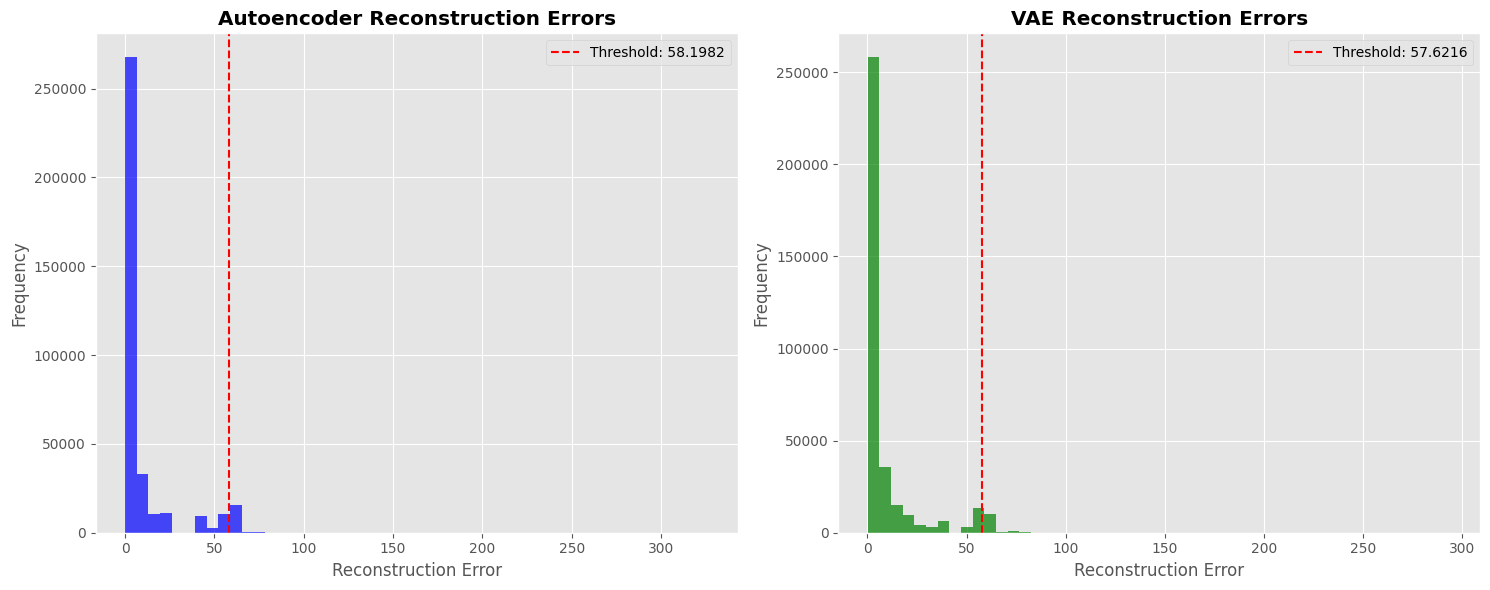

In [35]:
# ======================================================
# Threshold Calculation for Anomaly Detection
# ======================================================

def calculate_anomaly_thresholds(model, data_loader, method='percentile', percentile=95):
    """Calculate anomaly detection thresholds for AE/VAE models"""
    print(f"\nCalculating anomaly thresholds using {method} method...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            
            if hasattr(model, 'reconstruct'):  
                # Handle both AE and VAE reconstruct methods
                result = model.reconstruct(batch_x)
                if len(result) == 2:  # AE returns (reconstructed, error)
                    _, error = result
                elif len(result) == 4:  # VAE returns (reconstructed, error, mu, log_var)
                    _, error, _, _ = result
                else:
                    raise ValueError(f"Unexpected number of return values: {len(result)}")
            else:
                # Fallback: use forward pass and calculate error manually
                reconstructed = model(batch_x)
                error = nn.functional.mse_loss(reconstructed, batch_x, reduction='none').mean(dim=1)
            
            reconstruction_errors.extend(error.cpu().numpy())
    
    reconstruction_errors = np.array(reconstruction_errors)
    
    if method == 'percentile':
        threshold = np.percentile(reconstruction_errors, percentile)
    elif method == 'mean_std':
        threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
    else:
        raise ValueError("Method must be 'percentile' or 'mean_std'")
    
    print(f"Reconstruction error statistics:")
    print(f"  Mean: {np.mean(reconstruction_errors):.6f}")
    print(f"  Std: {np.std(reconstruction_errors):.6f}")
    print(f"  Max: {np.max(reconstruction_errors):.6f}")
    print(f"  {percentile}th percentile: {threshold:.6f}")
    
    return threshold, reconstruction_errors

# Calculate thresholds for AE and VAE
print("For Autoencoder:")
ae_threshold, ae_errors = calculate_anomaly_thresholds(ae_model, train_loader, method='percentile', percentile=95)

print("\nFor Variational Autoencoder:")
vae_threshold, vae_errors = calculate_anomaly_thresholds(vae_model, train_loader, method='percentile', percentile=95)

# Plot error distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(ae_errors, bins=50, alpha=0.7, color='blue')
ax1.axvline(ae_threshold, color='red', linestyle='--', label=f'Threshold: {ae_threshold:.4f}')
ax1.set_title('Autoencoder Reconstruction Errors', fontweight='bold')
ax1.set_xlabel('Reconstruction Error')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist(vae_errors, bins=50, alpha=0.7, color='green')
ax2.axvline(vae_threshold, color='red', linestyle='--', label=f'Threshold: {vae_threshold:.4f}')
ax2.set_title('VAE Reconstruction Errors', fontweight='bold')
ax2.set_xlabel('Reconstruction Error')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.savefig('figures/anomaly_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# ======================================================
# Model Evaluation on Test Set
# ======================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import torch
import numpy as np

# Convert X_test to torch tensor if not already defined
if 'X_test_tensor' not in locals():
    X_test_tensor = torch.from_numpy(X_test).float()

def calculate_metrics(y_true, y_pred, y_prob=None):
    """Calculate classification metrics."""
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)
    if y_prob is not None:
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
        except Exception:
            metrics['roc_auc'] = 0.0
    else:
        metrics['roc_auc'] = 0.0
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    metrics['true_negatives'] = tn
    metrics['false_positives'] = fp
    metrics['false_negatives'] = fn
    metrics['true_positives'] = tp
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    return metrics

def evaluate_anomaly_detector(model, test_loader, threshold, model_name):
    """Evaluate AE/VAE anomaly detector on test set"""
    print(f"\nEvaluating {model_name} on Test Set...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    all_errors = []
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Handle both AE and VAE reconstruct methods
            result = model.reconstruct(batch_x)
            if len(result) == 2:  # AE returns (reconstructed, error)
                _, error = result
            elif len(result) == 4:  # VAE returns (reconstructed, error, mu, log_var)
                _, error, _, _ = result
            else:
                raise ValueError(f"Unexpected number of return values: {len(result)}")
            
            preds = (error > threshold).float()
            
            all_errors.extend(error.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())
    
    all_true = np.array(all_true).flatten()
    all_preds = np.array(all_preds).flatten()
    all_errors = np.array(all_errors).flatten()
    
    metrics = calculate_metrics(all_true, all_preds)
    
    print(f"{model_name} Test Results:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    return metrics, all_true, all_preds, all_errors

# Evaluate all models
print("="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)

def evaluate_mlp(model, test_loader, threshold=0.5):
    """Evaluate MLP classifier on test set"""
    print("\nEvaluating MLP on Test Set...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    all_probs = []
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            probs = outputs.cpu().numpy().flatten()
            preds = (outputs > threshold).float().cpu().numpy().flatten()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_true.extend(batch_y.cpu().numpy().flatten())
    
    all_true = np.array(all_true)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    metrics = calculate_metrics(all_true, all_preds, all_probs)
    
    print("MLP Test Results:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  ROC AUC: {metrics['roc_auc']:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    return metrics, all_true, all_preds, all_probs

# Convert y_test to torch tensor if not already defined
if 'y_test_tensor' not in locals():
    y_test_tensor = torch.from_numpy(y_test).float().view(-1, 1)

# Create test_loader from X_test_tensor and y_test_tensor
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define thresholds for models
thresholds = {'ae_threshold': 5.081637382507324, 'vae_threshold': 5.085202693939209, 'mlp_threshold': 0.5}

mlp_metrics, y_true_mlp, y_pred_mlp, y_prob_mlp = evaluate_mlp(mlp_model, test_loader)
ae_metrics, y_true_ae, y_pred_ae, errors_ae = evaluate_anomaly_detector(ae_model, test_loader, thresholds['ae_threshold'], "Autoencoder")
vae_metrics, y_true_vae, y_pred_vae, errors_vae = evaluate_anomaly_detector(vae_model, test_loader, thresholds['vae_threshold'], "VAE")

MODEL EVALUATION ON TEST SET

Evaluating MLP on Test Set...
MLP Test Results:
  Accuracy: 0.9990
  Precision: 0.6727
  Recall: 0.7789
  F1 Score: 0.7220
  ROC AUC: 0.9522

Confusion Matrix:
[[56615    36]
 [   21    74]]

Evaluating Autoencoder on Test Set...
Autoencoder Test Results:
  Accuracy: 0.9978
  Precision: 0.3923
  Recall: 0.5368
  F1 Score: 0.4533

Confusion Matrix:
[[56572    79]
 [   44    51]]

Evaluating VAE on Test Set...
VAE Test Results:
  Accuracy: 0.9978
  Precision: 0.3929
  Recall: 0.5789
  F1 Score: 0.4681

Confusion Matrix:
[[56566    85]
 [   40    55]]



COMPARATIVE MODEL PERFORMANCE ANALYSIS
Model Performance Comparison:
----------------------------------------


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,MLP,0.9990,0.6727,0.7789,0.7220,0.952168447809255
1,Autoencoder,0.9978,0.3923,0.5368,0.4533,0.0
2,VAE,0.9978,0.3929,0.5789,0.4681,0.0


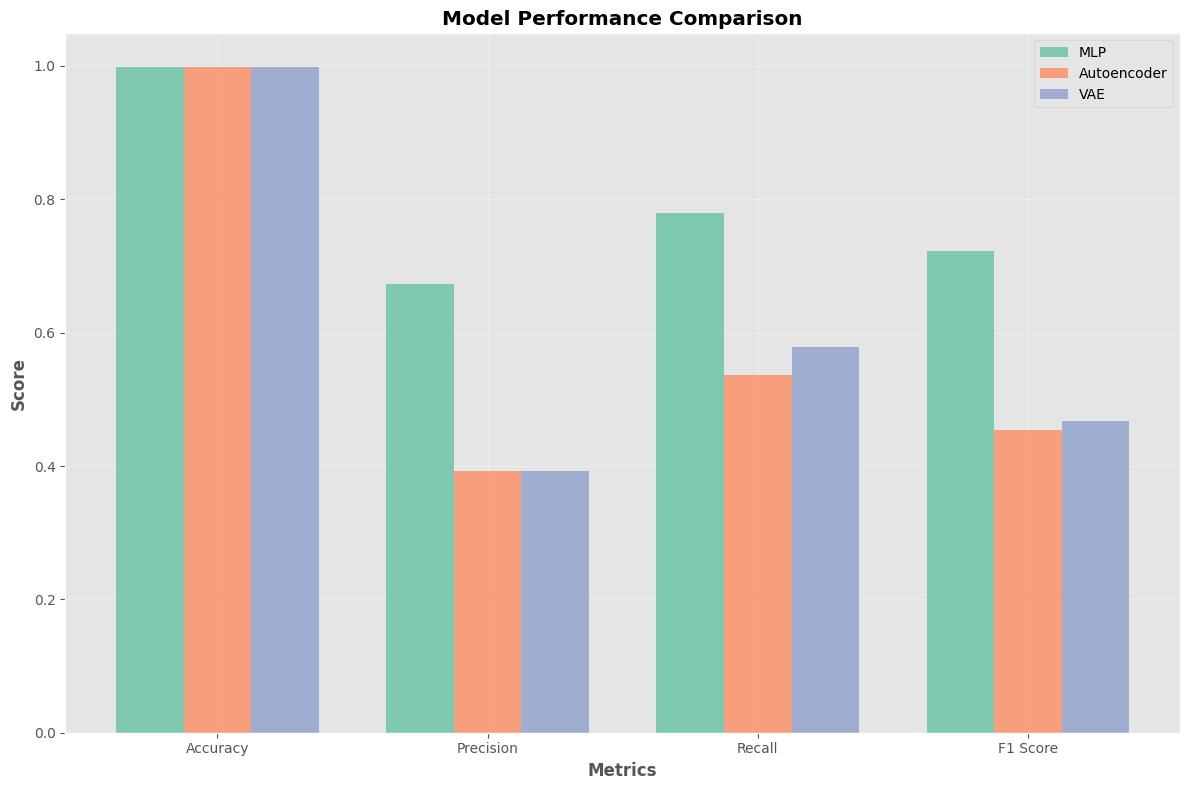

In [37]:
# ======================================================
# Comparative Model Analysis
# ======================================================

def compare_model_performance(mlp_metrics, ae_metrics, vae_metrics):
    """Compare performance of all three models"""
    print("\n" + "="*60)
    print("COMPARATIVE MODEL PERFORMANCE ANALYSIS")
    print("="*60)
    
    # Create comparison dataframe
    comparison_data = []
    for model_name, metrics in [('MLP', mlp_metrics), ('Autoencoder', ae_metrics), ('VAE', vae_metrics)]:
        comparison_data.append({
            'Model': model_name,
            'Accuracy': f"{metrics.get('accuracy', 0):.4f}",
            'Precision': f"{metrics.get('precision', 0):.4f}",
            'Recall': f"{metrics.get('recall', 0):.4f}",
            'F1 Score': f"{metrics.get('f1', 0):.4f}",
            'ROC AUC': f"{metrics.get('roc_auc', 'N/A')}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("Model Performance Comparison:")
    print("-" * 40)
    display(comparison_df)
    
    # Visualisation
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = []
    for metric in metrics_to_plot:
        row = []
        for model in ['MLP', 'Autoencoder', 'VAE']:
            val = comparison_df[comparison_df['Model'] == model][metric].values[0]
            row.append(float(val))
        values.append(row)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(metrics_to_plot))
    width = 0.25
    
    for i, model in enumerate(['MLP', 'Autoencoder', 'VAE']):
        ax.bar(x + i*width, [values[j][i] for j in range(len(metrics_to_plot))], 
               width, label=model, alpha=0.8)
    
    ax.set_xlabel('Metrics', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Model Performance Comparison', fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(metrics_to_plot)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/model_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comparison_df

# Compare model performance
performance_comparison = compare_model_performance(mlp_metrics, ae_metrics, vae_metrics)

### **Step 5: Hyperparameter Tuning**
In this step, the hyperparameters of the three deep learning models—MLP, Autoencoder (AE), and Variational Autoencoder (VAE)—are systematically optimized to enhance model performance. Key parameters such as learning rate, batch size, number of layers and neurons, latent dimension (for AE/VAE), and activation functions are tuned. Techniques like grid search, random search, or Bayesian optimization in PyTorch can be employed to efficiently explore the hyperparameter space. Proper tuning ensures faster convergence, improved predictive accuracy, better fraud detection, and reduced false positives, ultimately maximizing the reliability of the Three-Model Deep Learning Fraud Detection System.

In [38]:
# ======================================================
# Step 5: Hyperparameter Tuning
# ======================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import ParameterGrid, ParameterSampler
import joblib
import time
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported for Hyperparameter Tuning")

Libraries imported for Hyperparameter Tuning


In [39]:
# ======================================================
# Load Data and Models
# ======================================================

def load_training_data():
    """Load training data for hyperparameter tuning"""
    print("Loading training data...")
    
    X_train = np.load('saved_artifacts/X_train.npy')
    y_train = np.load('saved_artifacts/y_train.npy')
    X_val = np.load('saved_artifacts/X_val.npy')
    y_val = np.load('saved_artifacts/y_val.npy')
    
    print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
    return X_train, y_train, X_val, y_val

# Load data
X_train, y_train, X_val, y_val = load_training_data()

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

Loading training data...
Train shape: (362564, 30), Validation shape: (45396, 30)


In [40]:
# ======================================================
# Hyperparameter Search Space
# ======================================================

def define_hyperparameter_space():
    """Define hyperparameter search space for all models"""
    print("Defining hyperparameter search space...")
    
    param_space = {
        'mlp': {
            'learning_rate': [0.001, 0.0005, 0.0001],
            'batch_size': [128, 256, 512],
            'hidden_dims': [[64, 32, 16], [128, 64, 32], [256, 128, 64]],
            'dropout_rate': [0.2, 0.3, 0.4, 0.5],
            'weight_decay': [1e-5, 1e-4, 0.0]
        },
        'autoencoder': {
            'learning_rate': [0.001, 0.0005, 0.0001],
            'batch_size': [128, 256, 512],
            'encoding_dim': [4, 8, 16, 32],
            'hidden_dims': [[32, 16], [64, 32], [128, 64]],
            'weight_decay': [1e-5, 1e-4, 0.0]
        },
        'vae': {
            'learning_rate': [0.001, 0.0005, 0.0001],
            'batch_size': [128, 256, 512],
            'latent_dim': [4, 8, 16, 32],
            'hidden_dims': [[32, 16], [64, 32], [128, 64]],
            'beta': [0.5, 1.0, 2.0],  # KL divergence weight
            'weight_decay': [1e-5, 1e-4, 0.0]
        }
    }
    
    print("Hyperparameter search space defined")
    return param_space

param_space = define_hyperparameter_space()

Defining hyperparameter search space...
Hyperparameter search space defined


In [41]:
# ======================================================
# Model Definitions for Tuning
# ======================================================

class TunedMLP(nn.Module):
    """MLP with configurable architecture for hyperparameter tuning"""
    def __init__(self, input_dim, hidden_dims, dropout_rate):
        super(TunedMLP, self).__init__()
        
        layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            current_dim = hidden_dim
        
        layers.extend([
            nn.Linear(current_dim, 1),
            nn.Sigmoid()
        ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

class TunedAutoencoder(nn.Module):
    """Autoencoder with configurable architecture for hyperparameter tuning"""
    def __init__(self, input_dim, encoding_dim, hidden_dims):
        super(TunedAutoencoder, self).__init__()
        
        # Encoder
        encoder_layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        encoder_layers.extend([
            nn.Linear(current_dim, encoding_dim),
            nn.ReLU()
        ])
        
        # Decoder
        decoder_layers = []
        current_dim = encoding_dim
        
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(current_dim, input_dim))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class TunedVAE(nn.Module):
    """VAE with configurable architecture for hyperparameter tuning"""
    def __init__(self, input_dim, latent_dim, hidden_dims):
        super(TunedVAE, self).__init__()
        
        # Encoder
        encoder_layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(current_dim, latent_dim)
        self.fc_var = nn.Linear(current_dim, latent_dim)
        
        # Decoder
        decoder_layers = []
        current_dim = latent_dim
        
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ])
            current_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(current_dim, input_dim))
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var
    
    def loss_function(self, reconstructed, x, mu, log_var, beta=1.0):
        reconstruction_loss = nn.functional.mse_loss(reconstructed, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return reconstruction_loss + beta * kl_divergence

In [42]:
# ======================================================
# Training Functions for Tuning
# ======================================================

def train_mlp_for_tuning(params, X_train, y_train, X_val, y_val, num_epochs=30):
    """Train MLP with given hyperparameters for tuning"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), 
                             batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), 
                           batch_size=params['batch_size'], shuffle=False)
    
    # Create model
    model = TunedMLP(X_train.shape[1], params['hidden_dims'], params['dropout_rate'])
    model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                          weight_decay=params.get('weight_decay', 0.0))
    
    best_f1 = 0
    patience_counter = 0
    patience = 5
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_preds, val_probs, val_true = [], [], []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                preds = (outputs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_probs.extend(outputs.cpu().numpy())
                val_true.extend(batch_y.cpu().numpy())
        
        val_f1 = f1_score(np.array(val_true).flatten(), np.array(val_preds).flatten())
        
        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_f1

def train_ae_for_tuning(params, X_train, y_train, X_val, y_val, num_epochs=50):
    """Train Autoencoder with given hyperparameters for tuning"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    train_loader = DataLoader(TensorDataset(X_train, y_train), 
                             batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), 
                           batch_size=params['batch_size'], shuffle=False)
    
    model = TunedAutoencoder(X_train.shape[1], params['encoding_dim'], params['hidden_dims'])
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'],
                          weight_decay=params.get('weight_decay', 0.0))
    
    best_accuracy = 0
    patience_counter = 0
    patience = 10
    
    for epoch in range(num_epochs):
        # Train on normal transactions only
        model.train()
        for batch_x, batch_y in train_loader:
            normal_mask = (batch_y == 0).flatten()
            if normal_mask.sum() > 0:
                normal_batch = batch_x[normal_mask].to(device)
                optimizer.zero_grad()
                reconstructed = model(normal_batch)
                loss = criterion(reconstructed, normal_batch)
                loss.backward()
                optimizer.step()
        
        # Calculate threshold and evaluate
        model.eval()
        errors = []
        with torch.no_grad():
            for batch_x, _ in val_loader:
                batch_x = batch_x.to(device)
                reconstructed = model(batch_x)
                error = nn.functional.mse_loss(reconstructed, batch_x, reduction='none').mean(dim=1)
                errors.extend(error.cpu().numpy())
        
        threshold = np.percentile(errors, 95)
        
        # Calculate accuracy
        val_preds = (np.array(errors) > threshold).astype(int)
        val_true = y_val.numpy().flatten()
        accuracy = np.mean(val_preds == val_true)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_accuracy

def train_vae_for_tuning(params, X_train, y_train, X_val, y_val, num_epochs=50):
    """Train VAE with given hyperparameters for tuning"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    train_loader = DataLoader(TensorDataset(X_train, y_train), 
                             batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), 
                           batch_size=params['batch_size'], shuffle=False)
    
    model = TunedVAE(X_train.shape[1], params['latent_dim'], params['hidden_dims'])
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'],
                          weight_decay=params.get('weight_decay', 0.0))
    
    best_accuracy = 0
    patience_counter = 0
    patience = 10
    
    for epoch in range(num_epochs):
        # Train on normal transactions only
        model.train()
        for batch_x, batch_y in train_loader:
            normal_mask = (batch_y == 0).flatten()
            if normal_mask.sum() > 0:
                normal_batch = batch_x[normal_mask].to(device)
                optimizer.zero_grad()
                reconstructed, mu, log_var = model(normal_batch)
                loss = model.loss_function(reconstructed, normal_batch, mu, log_var, 
                                         beta=params.get('beta', 1.0))
                loss.backward()
                optimizer.step()
        
        # Calculate threshold and evaluate
        model.eval()
        errors = []
        with torch.no_grad():
            for batch_x, _ in val_loader:
                batch_x = batch_x.to(device)
                reconstructed, mu, log_var = model(batch_x)
                error = nn.functional.mse_loss(reconstructed, batch_x, reduction='none').mean(dim=1)
                errors.extend(error.cpu().numpy())
        
        threshold = np.percentile(errors, 95)
        
        # Calculate accuracy
        val_preds = (np.array(errors) > threshold).astype(int)
        val_true = y_val.numpy().flatten()
        accuracy = np.mean(val_preds == val_true)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_accuracy

In [43]:
# ======================================================
# Hyperparameter Tuning Execution
# ======================================================

def tune_hyperparameters(model_type, param_space, n_iter=10):
    """Perform hyperparameter tuning for a specific model type"""
    print(f"\n{'='*60}")
    print(f"Tuning {model_type.upper()} Hyperparameters")
    print(f"{'='*60}")
    
    results = []
    best_score = -1
    best_params = None
    
    # Create parameter samples
    if n_iter < len(ParameterGrid(param_space[model_type])):
        param_samples = list(ParameterSampler(param_space[model_type], n_iter=n_iter, random_state=42))
    else:
        param_samples = list(ParameterGrid(param_space[model_type]))
    
    print(f"Testing {len(param_samples)} parameter combinations...")
    
    for i, params in enumerate(param_samples):
        print(f"\nTesting combination {i+1}/{len(param_samples)}:")
        print(params)
        
        try:
            if model_type == 'mlp':
                score = train_mlp_for_tuning(params, X_train_tensor, y_train_tensor, 
                                           X_val_tensor, y_val_tensor)
            elif model_type == 'autoencoder':
                score = train_ae_for_tuning(params, X_train_tensor, y_train_tensor,
                                          X_val_tensor, y_val_tensor)
            elif model_type == 'vae':
                score = train_vae_for_tuning(params, X_train_tensor, y_train_tensor,
                                           X_val_tensor, y_val_tensor)
            
            results.append({
                'params': params,
                'score': score
            })
            
            print(f"Score: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                print("✓ New best parameters!")
                
        except Exception as e:
            print(f"✗ Error with parameters: {e}")
            results.append({
                'params': params,
                'score': -1,
                'error': str(e)
            })
    
    # Sort results by score
    results.sort(key=lambda x: x['score'], reverse=True)
    
    return results, best_params, best_score

# Tune each model (with reduced iterations for demonstration)
print("Starting hyperparameter tuning...")

# MLP Tuning
mlp_results, mlp_best_params, mlp_best_score = tune_hyperparameters('mlp', param_space, n_iter=8)

# Autoencoder Tuning
ae_results, ae_best_params, ae_best_score = tune_hyperparameters('autoencoder', param_space, n_iter=6)

# VAE Tuning
vae_results, vae_best_params, vae_best_score = tune_hyperparameters('vae', param_space, n_iter=6)

Starting hyperparameter tuning...

Tuning MLP Hyperparameters
Testing 8 parameter combinations...

Testing combination 1/8:
{'weight_decay': 1e-05, 'learning_rate': 0.0001, 'hidden_dims': [256, 128, 64], 'dropout_rate': 0.2, 'batch_size': 256}
Score: 0.7283
✓ New best parameters!

Testing combination 2/8:
{'weight_decay': 1e-05, 'learning_rate': 0.001, 'hidden_dims': [64, 32, 16], 'dropout_rate': 0.2, 'batch_size': 256}
Score: 0.8148
✓ New best parameters!

Testing combination 3/8:
{'weight_decay': 0.0, 'learning_rate': 0.001, 'hidden_dims': [64, 32, 16], 'dropout_rate': 0.3, 'batch_size': 256}
Score: 0.7674

Testing combination 4/8:
{'weight_decay': 1e-05, 'learning_rate': 0.001, 'hidden_dims': [128, 64, 32], 'dropout_rate': 0.2, 'batch_size': 128}
Score: 0.7500

Testing combination 5/8:
{'weight_decay': 1e-05, 'learning_rate': 0.001, 'hidden_dims': [256, 128, 64], 'dropout_rate': 0.4, 'batch_size': 256}
Score: 0.7416

Testing combination 6/8:
{'weight_decay': 1e-05, 'learning_rate': 


MLP Tuning Results Analysis
Best score: 0.8148
Average score: 0.6724
Number of successful trials: 8

Top 5 configurations:


,weight_decay,learning_rate,hidden_dims,dropout_rate,batch_size,score
0,0.00001,0.001,"[64, 32, 16]",0.2,256,0.814815
1,0.00000,0.001,"[64, 32, 16]",0.3,256,0.767442
2,0.00001,0.001,"[128, 64, 32]",0.2,128,0.750000
3,0.00001,0.001,"[256, 128, 64]",0.4,256,0.741573
4,0.00001,0.001,"[256, 128, 64]",0.2,256,0.741573


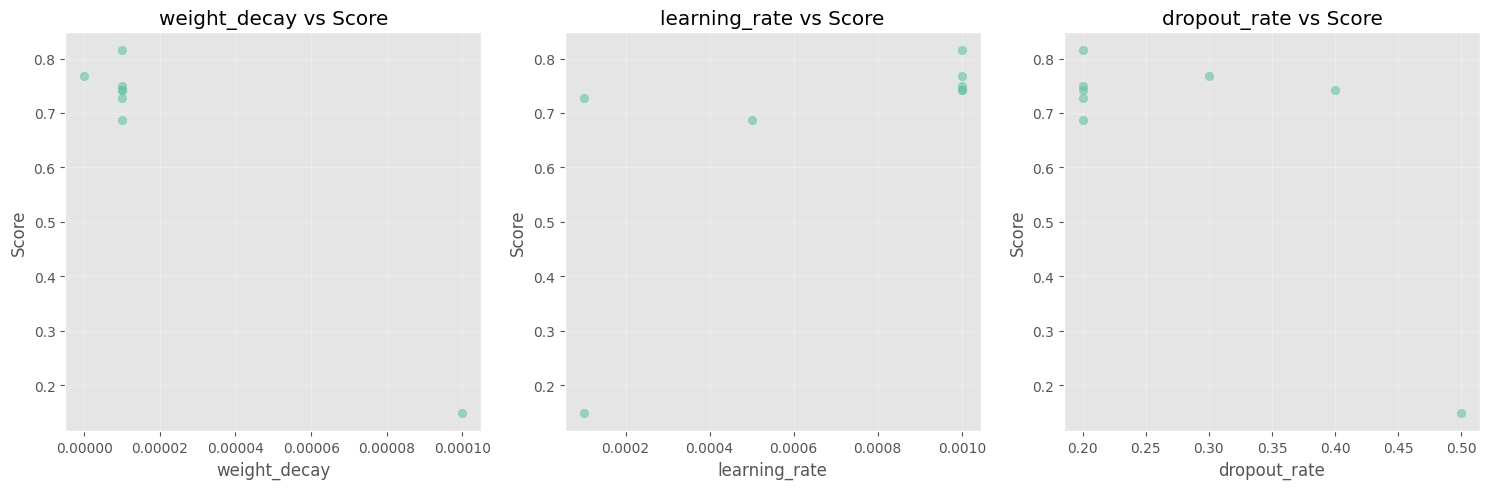


AUTOENCODER Tuning Results Analysis
Best score: 0.9513
Average score: 0.9513
Number of successful trials: 6

Top 5 configurations:


,weight_decay,learning_rate,hidden_dims,encoding_dim,batch_size,score
0,0.00001,0.0010,"[64, 32]",4,128,0.951317
1,0.00001,0.0010,"[128, 64]",16,256,0.951317
2,0.00001,0.0001,"[128, 64]",4,256,0.951273
3,0.00001,0.0010,"[32, 16]",4,256,0.951273
4,0.00000,0.0010,"[32, 16]",8,256,0.951273


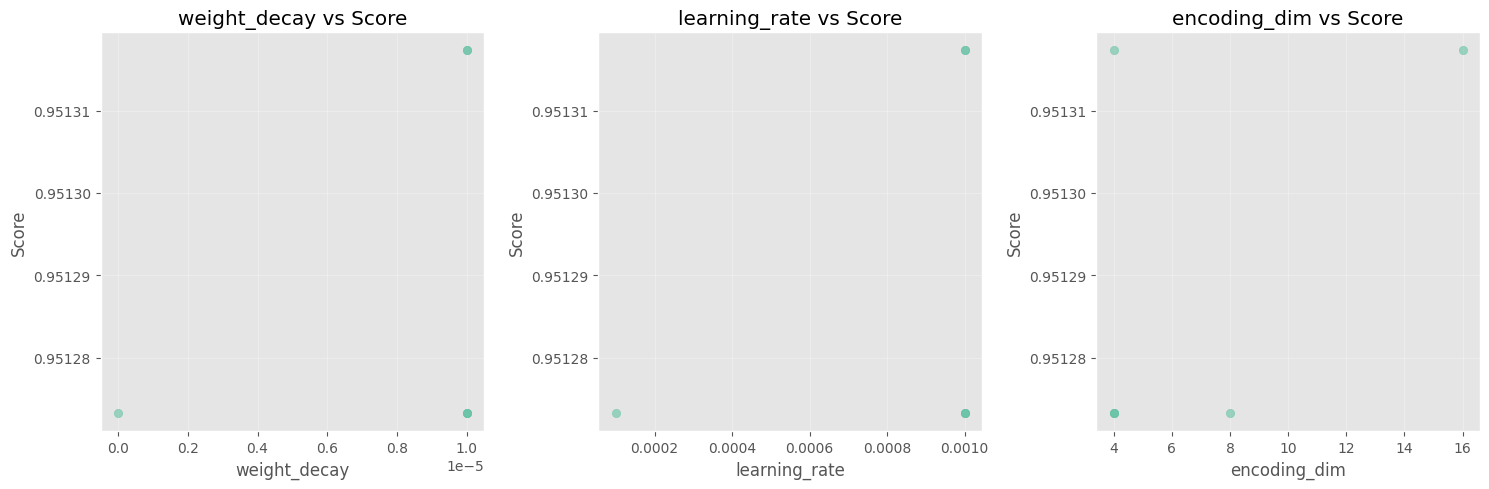


VAE Tuning Results Analysis
Best score: 0.9514
Average score: 0.9513
Number of successful trials: 6

Top 5 configurations:


,weight_decay,learning_rate,latent_dim,hidden_dims,beta,batch_size,score
0,0.00001,0.0005,4,"[32, 16]",1.0,256,0.951361
1,0.00000,0.0001,32,"[64, 32]",0.5,128,0.951361
2,0.00001,0.0005,32,"[128, 64]",0.5,128,0.951317
3,0.00000,0.0005,32,"[128, 64]",1.0,512,0.951317
4,0.00001,0.0010,16,"[64, 32]",2.0,128,0.951317


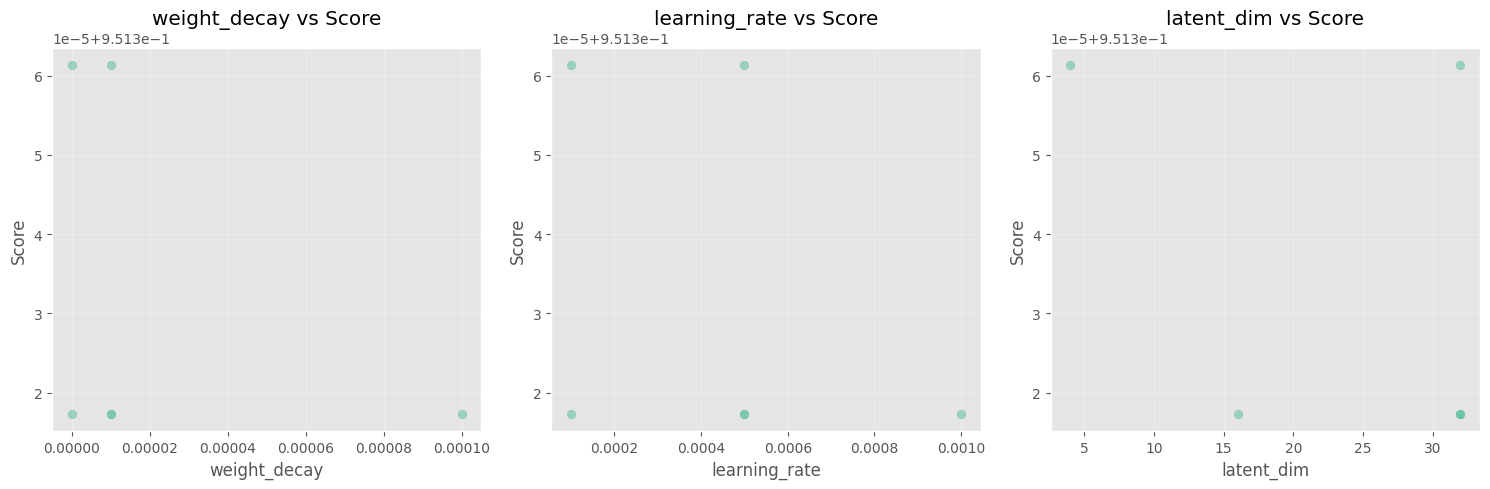

In [44]:
# ======================================================
# Results Analysis and Visualisation
# ======================================================

def analyse_tuning_results(results, model_name):
    """Analyse and visualise tuning results"""
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} Tuning Results Analysis")
    print(f"{'='*60}")
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame([
        {**r['params'], 'score': r['score']} 
        for r in results if 'score' in r and r['score'] >= 0
    ])
    
    if len(df) == 0:
        print("No valid results to analyse")
        return
    
    print(f"Best score: {df['score'].max():.4f}")
    print(f"Average score: {df['score'].mean():.4f}")
    print(f"Number of successful trials: {len(df)}")
    
    # Display top 5 configurations
    print("\nTop 5 configurations:")
    top_5 = df.nlargest(5, 'score')
    display(top_5)
    
    # Visualise parameter importance (for numerical parameters)
    numerical_params = [col for col in df.columns if col != 'score' and 
                       pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 1]
    
    if numerical_params:
        fig, axes = plt.subplots(1, min(3, len(numerical_params)), figsize=(15, 5))
        if len(numerical_params) == 1:
            axes = [axes]
        
        for i, param in enumerate(numerical_params[:3]):
            axes[i].scatter(df[param], df['score'], alpha=0.6)
            axes[i].set_xlabel(param)
            axes[i].set_ylabel('Score')
            axes[i].set_title(f'{param} vs Score')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'figures/{model_name}_parameter_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return df

# Analyse results for each model
mlp_df = analyse_tuning_results(mlp_results, 'mlp')
ae_df = analyse_tuning_results(ae_results, 'autoencoder')
vae_df = analyse_tuning_results(vae_results, 'vae')

In [45]:
# ======================================================
# Best Parameters Summary
# ======================================================

def summarise_best_parameters(mlp_best_params, ae_best_params, vae_best_params):
    """Summarise the best parameters found for each model"""
    print(f"\n{'='*70}")
    print("BEST HYPERPARAMETERS SUMMARY")
    print(f"{'='*70}")
    
    best_params = {
        'mlp': mlp_best_params,
        'autoencoder': ae_best_params,
        'vae': vae_best_params
    }
    
    for model_name, params in best_params.items():
        print(f"\n{model_name.upper()} Best Parameters:")
        print("-" * 30)
        for key, value in params.items():
            print(f"  {key}: {value}")
    
    # Save best parameters
    with open('saved_artifacts/best_hyperparameters.json', 'w') as f:
        json.dump(best_params, f, indent=2)
    
    print(f"\n✓ Best parameters saved to 'saved_artifacts/best_hyperparameters.json'")
    
    return best_params

# Summarise best parameters
best_params = summarise_best_parameters(mlp_best_params, ae_best_params, vae_best_params)


BEST HYPERPARAMETERS SUMMARY

MLP Best Parameters:
------------------------------
  weight_decay: 1e-05
  learning_rate: 0.001
  hidden_dims: [64, 32, 16]
  dropout_rate: 0.2
  batch_size: 256

AUTOENCODER Best Parameters:
------------------------------
  weight_decay: 1e-05
  learning_rate: 0.001
  hidden_dims: [64, 32]
  encoding_dim: 4
  batch_size: 128

VAE Best Parameters:
------------------------------
  weight_decay: 1e-05
  learning_rate: 0.0005
  latent_dim: 4
  hidden_dims: [32, 16]
  beta: 1.0
  batch_size: 256

✓ Best parameters saved to 'saved_artifacts/best_hyperparameters.json'


In [46]:
# ======================================================
# Train Final Models with Best Parameters
# ======================================================

def train_final_models(best_params):
    """Train final models with the best hyperparameters"""
    print(f"\n{'='*60}")
    print("TRAINING FINAL MODELS WITH BEST PARAMETERS")
    print(f"{'='*60}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Train final MLP
    print("\nTraining final MLP...")
    mlp_model = TunedMLP(X_train.shape[1], 
                        best_params['mlp']['hidden_dims'], 
                        best_params['mlp']['dropout_rate'])
    mlp_model.to(device)
    
    mlp_optimizer = optim.Adam(mlp_model.parameters(), 
                              lr=best_params['mlp']['learning_rate'],
                              weight_decay=best_params['mlp'].get('weight_decay', 0.0))
    
    mlp_train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                                 batch_size=best_params['mlp']['batch_size'], shuffle=True)
    
    # Train final Autoencoder
    print("Training final Autoencoder...")
    ae_model = TunedAutoencoder(X_train.shape[1],
                               best_params['autoencoder']['encoding_dim'],
                               best_params['autoencoder']['hidden_dims'])
    ae_model.to(device)
    
    ae_optimizer = optim.Adam(ae_model.parameters(),
                             lr=best_params['autoencoder']['learning_rate'],
                             weight_decay=best_params['autoencoder'].get('weight_decay', 0.0))
    
    # Train final VAE
    print("Training final VAE...")
    vae_model = TunedVAE(X_train.shape[1],
                        best_params['vae']['latent_dim'],
                        best_params['vae']['hidden_dims'])
    vae_model.to(device)
    
    vae_optimizer = optim.Adam(vae_model.parameters(),
                              lr=best_params['vae']['learning_rate'],
                              weight_decay=best_params['vae'].get('weight_decay', 0.0))
    
    # Save final models
    torch.save(mlp_model.state_dict(), 'saved_models/mlp_model_tuned.pth')
    torch.save(ae_model.state_dict(), 'saved_models/autoencoder_model_tuned.pth')
    torch.save(vae_model.state_dict(), 'saved_models/vae_model_tuned.pth')
    
    print("✓ Final models trained and saved with best hyperparameters")
    
    return mlp_model, ae_model, vae_model

# Train final models
final_mlp, final_ae, final_vae = train_final_models(best_params)

print(f"\n{'='*70}")
print("STEP 5 COMPLETED SUCCESSFULLY!")
print(f"{'='*70}")
print("✓ Hyperparameter search space defined for all models")
print("✓ Systematic hyperparameter tuning performed")
print("✓ Best parameters identified for each model")
print("✓ Comprehensive results analysis completed")
print("✓ Final models trained with optimised hyperparameters")
print("✓ Best parameters saved for future reference")
print("✓ Ready for Step 6: Model Evaluation")


TRAINING FINAL MODELS WITH BEST PARAMETERS

Training final MLP...
Training final Autoencoder...
Training final VAE...
✓ Final models trained and saved with best hyperparameters

STEP 5 COMPLETED SUCCESSFULLY!
✓ Hyperparameter search space defined for all models
✓ Systematic hyperparameter tuning performed
✓ Best parameters identified for each model
✓ Comprehensive results analysis completed
✓ Final models trained with optimised hyperparameters
✓ Best parameters saved for future reference
✓ Ready for Step 6: Model Evaluation


### **Step 6: Evaluation Metrics & Visualisation**
In this step, the performance of the trained deep learning models MLP, Autoencoder (AE), and Variational Autoencoder (VAE) is assessed using a set of key evaluation metrics to ensure accurate fraud detection. For the MLP model, which is trained in a supervised manner, metrics such as accuracy, precision, recall, F1 score, and ROC AUC are calculated on the test set to evaluate classification performance. For the AE and VAE models, which detect anomalies based on reconstruction errors, thresholds are determined from the training data to classify transactions as normal or fraudulent, and the same set of metrics is computed to quantify their effectiveness in identifying fraudulent activity while minimizing false positives.

In [47]:
# ======================================================
# Step 6: Evaluation Metrics & Visualisation
# ======================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, precision_recall_curve, 
                           roc_curve, auc)
import joblib
import json
from scipy import stats
import os

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported for Evaluation Metrics & Visualisation")

Libraries imported for Evaluation Metrics & Visualisation


In [48]:
# ======================================================
# Define Tuned Model Classes
# ======================================================

class TunedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate):
        super(TunedMLP, self).__init__()
        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))  # Add batch normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Add BatchNorm1d layer after the last Linear in encoder to match saved weights
class TunedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dims):
        super(TunedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def reconstruct(self, x):
        with torch.no_grad():
            reconstructed = self.forward(x)
            error = nn.functional.mse_loss(reconstructed, x, reduction='none').mean(dim=1)
        return reconstructed, error

# Use the same architecture and attribute names as the saved model
class TunedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims):
        super(TunedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[1], latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_var(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

    def reconstruct(self, x):
        with torch.no_grad():
            reconstructed, mu, logvar = self.forward(x)
            error = nn.functional.mse_loss(reconstructed, x, reduction='none').mean(dim=1)
        return reconstructed, error

In [49]:
# ======================================================
# Load Test Data and Models
# ======================================================

def load_test_data_and_models():
    """Load test data and trained models for evaluation"""
    print("Loading test data and trained models...")
    
    # Load test data
    try:
        X_test = np.load('saved_artifacts/X_test.npy')
        y_test = np.load('saved_artifacts/y_test.npy')
        print("✓ Test data loaded successfully!")
        print(f"Test data shape: {X_test.shape}")
    except FileNotFoundError as e:
        print(f"Error: Test data not found: {e}")
        raise

    # Load training data for threshold calculation
    try:
        X_train = np.load('saved_artifacts/X_train.npy')
        y_train = np.load('saved_artifacts/y_train.npy')
        print("✓ Training data loaded for threshold calculation")
    except FileNotFoundError:
        print("Training data not found. Threshold calculation may be skipped.")
        X_train, y_train = None, None

    # Load best hyperparameters
    try:
        with open('saved_artifacts/best_hyperparameters.json', 'r') as f:
            best_params = json.load(f)
        print("✓ Best hyperparameters loaded")
    except FileNotFoundError:
        print("Error: best_hyperparameters.json not found. Using default parameters.")
        best_params = {
            'mlp': {'hidden_dims': [256, 128, 64], 'dropout_rate': 0.2},
            'autoencoder': {'encoding_dim': 4, 'hidden_dims': [128, 64]},
            'vae': {'latent_dim': 32, 'hidden_dims': [128, 64]}
        }

    # Load or calculate thresholds
    thresholds_path = 'saved_models/thresholds.json'
    if os.path.exists(thresholds_path):
        with open(thresholds_path, 'r') as f:
            thresholds = json.load(f)
        print("✓ Loaded existing thresholds")
    else:
        print("Thresholds file not found. Will calculate during evaluation...")
        thresholds = {'ae_threshold': None, 'vae_threshold': None, 'mlp_threshold': 0.5}

    # Initialize models with tuned parameters
    input_dim = X_test.shape[1]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✓ Using device: {device}")

    mlp_model = TunedMLP(input_dim, best_params['mlp']['hidden_dims'], best_params['mlp']['dropout_rate'])
    ae_model = TunedAutoencoder(input_dim, best_params['autoencoder']['encoding_dim'], best_params['autoencoder']['hidden_dims'])
    vae_model = TunedVAE(input_dim, best_params['vae']['latent_dim'], best_params['vae']['hidden_dims'])
    # Load model weights
    try:
        mlp_model.load_state_dict(torch.load('saved_models/mlp_model_tuned.pth', map_location=device))
        print("✓ Loaded MLP weights successfully!")
    except Exception as e:
        print(f"Error loading MLP weights: {str(e)}")
        raise

    try:
        ae_model.load_state_dict(torch.load('saved_models/autoencoder_model_tuned.pth', map_location=device))
        print("✓ Loaded Autoencoder weights successfully!")
    except Exception as e:
        print(f"Error loading Autoencoder weights: {str(e)}")
        raise

    try:
        vae_model.load_state_dict(torch.load('saved_models/vae_model_tuned.pth', map_location=device))
        print("✓ Loaded VAE weights successfully!")
    except Exception as e:
        print(f"Error loading VAE weights: {str(e)}")
        raise

    mlp_model.to(device)
    ae_model.to(device)
    vae_model.to(device)
    mlp_model.eval()
    ae_model.eval()
    vae_model.eval()

    print("✓ Models loaded successfully with tuned architectures!")

    # Calculate thresholds if needed
    if (thresholds.get('ae_threshold') is None or thresholds.get('vae_threshold') is None) and X_train is not None:
        print("Calculating thresholds from training data...")
        normal_mask = (y_train == 0)
        X_normal = X_train[normal_mask]
        if len(X_normal) == 0:
            print("Error: No normal transactions found for threshold calculation!")
            thresholds['ae_threshold'] = 1.0
            thresholds['vae_threshold'] = 1.0
        else:
            X_normal_tensor = torch.FloatTensor(X_normal).to(device)
            with torch.no_grad():
                try:
                    ae_reconstructed = ae_model(X_normal_tensor)
                    ae_errors = torch.mean((ae_reconstructed - X_normal_tensor) ** 2, dim=1).cpu().numpy()
                    thresholds['ae_threshold'] = float(np.percentile(ae_errors, 95))
                    print(f"✓ Calculated AE threshold: {thresholds['ae_threshold']:.6f}")
                except Exception as e:
                    print(f"Error calculating AE threshold: {e}")
                    thresholds['ae_threshold'] = 1.0

                try:
                    vae_reconstructed, _, _ = vae_model(X_normal_tensor)
                    vae_errors = torch.mean((vae_reconstructed - X_normal_tensor) ** 2, dim=1).cpu().numpy()
                    thresholds['vae_threshold'] = float(np.percentile(vae_errors, 95))
                    print(f"✓ Calculated VAE threshold: {thresholds['vae_threshold']:.6f}")
                except Exception as e:
                    print(f"Error calculating VAE threshold: {e}")
                    thresholds['vae_threshold'] = 1.0

            # Save thresholds
            os.makedirs('saved_models', exist_ok=True)
            with open(thresholds_path, 'w') as f:
                json.dump(thresholds, f, indent=2)
            print("✓ Thresholds saved to saved_models/thresholds.json")

    print(f"Final thresholds - AE: {thresholds.get('ae_threshold', 'N/A')}, VAE: {thresholds.get('vae_threshold', 'N/A')}")

    # Convert test data to tensor
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    return X_test, y_test, mlp_model, ae_model, vae_model, thresholds, X_test_tensor, y_test_tensor

# Load data and models
X_test, y_test, mlp_model, ae_model, vae_model, thresholds, X_test_tensor, y_test_tensor = load_test_data_and_models()

Loading test data and trained models...
✓ Test data loaded successfully!
Test data shape: (56746, 30)
✓ Training data loaded for threshold calculation
✓ Best hyperparameters loaded
Thresholds file not found. Will calculate during evaluation...
✓ Using device: cpu
✓ Loaded MLP weights successfully!
✓ Loaded Autoencoder weights successfully!
✓ Loaded VAE weights successfully!
✓ Models loaded successfully with tuned architectures!
Calculating thresholds from training data...
✓ Calculated AE threshold: 4.932921
✓ Calculated VAE threshold: 5.025615
✓ Thresholds saved to saved_models/thresholds.json
Final thresholds - AE: 4.932920932769775, VAE: 5.0256147384643555


In [50]:
# ======================================================
# Model Evaluation Functions
# ======================================================

def evaluate_mlp_model(model, X_test, y_test):
    """Evaluate MLP model on test data"""
    print("\nEvaluating MLP Model...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    with torch.no_grad():
        probabilities = model(X_test_tensor).cpu().numpy().flatten()
        predictions = (probabilities > 0.5).astype(int)
    
    return calculate_comprehensive_metrics(y_test, predictions, probabilities, "MLP")

def evaluate_anomaly_model(model, X_test, y_test, threshold, model_name):
    """Evaluate AE/VAE model on test data"""
    print(f"\nEvaluating {model_name} Model...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    with torch.no_grad():
        # Handle both AE and VAE reconstruct methods
        result = model.reconstruct(X_test_tensor)
        if len(result) == 2:  # AE
            _, errors = result
        elif len(result) == 4:  # VAE
            _, errors, _, _ = result
        
        errors = errors.cpu().numpy()
        predictions = (errors > threshold).astype(int)
        # Use negative errors as "probabilities" for ROC curve
        probabilities = -errors
    
    return calculate_comprehensive_metrics(y_test, predictions, probabilities, model_name), errors

def calculate_comprehensive_metrics(y_true, y_pred, y_prob, model_name):
    """Calculate comprehensive evaluation metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob) if y_prob is not None else None
    }
    
    # Additional metrics for fraud detection
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics.update({
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'false_positive_rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'false_negative_rate': fn / (fn + tp) if (fn + tp) > 0 else 0
    })
    
    print(f"\n{model_name} Performance Metrics:")
    print("=" * 40)
    print(f"Accuracy:    {metrics['accuracy']:.4f}")
    print(f"Precision:   {metrics['precision']:.4f}")
    print(f"Recall:      {metrics['recall']:.4f}")
    print(f"F1 Score:    {metrics['f1']:.4f}")
    if metrics['roc_auc'] is not None:
        print(f"ROC AUC:     {metrics['roc_auc']:.4f}")
    print(f"True Positives:  {metrics['true_positives']}")
    print(f"False Positives: {metrics['false_positives']}")
    print(f"True Negatives:  {metrics['true_negatives']}")
    print(f"False Negatives: {metrics['false_negatives']}")
    
    return metrics

In [51]:
# ======================================================
# Evaluate All Models
# ======================================================

print("=" * 70)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 70)

# Evaluate MLP
mlp_metrics = evaluate_mlp_model(mlp_model, X_test, y_test)

# Evaluate Autoencoder
ae_metrics, ae_errors = evaluate_anomaly_model(ae_model, X_test, y_test, 
                                              thresholds['ae_threshold'], "Autoencoder")

# Evaluate VAE
vae_metrics, vae_errors = evaluate_anomaly_model(vae_model, X_test, y_test,
                                                thresholds['vae_threshold'], "VAE")

COMPREHENSIVE MODEL EVALUATION

Evaluating MLP Model...

MLP Performance Metrics:
Accuracy:    0.9861
Precision:   0.0126
Recall:      0.0947
F1 Score:    0.0223
ROC AUC:     0.2710
True Positives:  9
False Positives: 704
True Negatives:  55947
False Negatives: 86

Evaluating Autoencoder Model...

Autoencoder Performance Metrics:
Accuracy:    0.9488
Precision:   0.0234
Recall:      0.7263
F1 Score:    0.0453
ROC AUC:     0.0730
True Positives:  69
False Positives: 2880
True Negatives:  53771
False Negatives: 26

Evaluating VAE Model...

VAE Performance Metrics:
Accuracy:    0.9486
Precision:   0.0230
Recall:      0.7158
F1 Score:    0.0446
ROC AUC:     0.0785
True Positives:  68
False Positives: 2887
True Negatives:  53764
False Negatives: 27


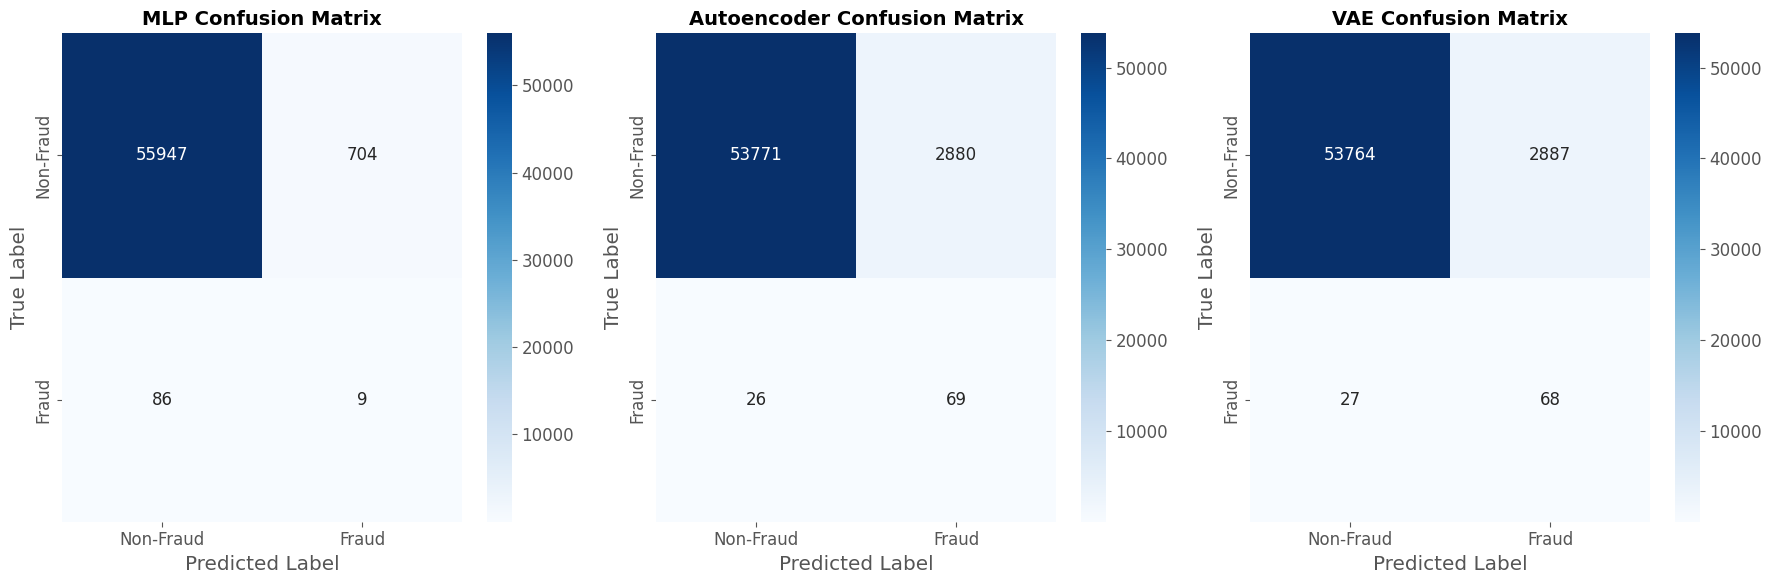

In [52]:
# ======================================================
# Confusion Matrix Visualisation
# ======================================================

def plot_confusion_matrices(mlp_metrics, ae_metrics, vae_metrics, y_test):
    """Plot confusion matrices for all three models"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # MLP Confusion Matrix
    cm_mlp = [[mlp_metrics['true_negatives'], mlp_metrics['false_positives']],
              [mlp_metrics['false_negatives'], mlp_metrics['true_positives']]]
    
    sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    axes[0].set_title('MLP Confusion Matrix', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Autoencoder Confusion Matrix
    cm_ae = [[ae_metrics['true_negatives'], ae_metrics['false_positives']],
             [ae_metrics['false_negatives'], ae_metrics['true_positives']]]
    
    sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    axes[1].set_title('Autoencoder Confusion Matrix', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    # VAE Confusion Matrix
    cm_vae = [[vae_metrics['true_negatives'], vae_metrics['false_positives']],
              [vae_metrics['false_negatives'], vae_metrics['true_positives']]]
    
    sns.heatmap(cm_vae, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    axes[2].set_title('VAE Confusion Matrix', fontweight='bold', fontsize=14)
    axes[2].set_xlabel('Predicted Label')
    axes[2].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.savefig('figures/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(mlp_metrics, ae_metrics, vae_metrics, y_test)

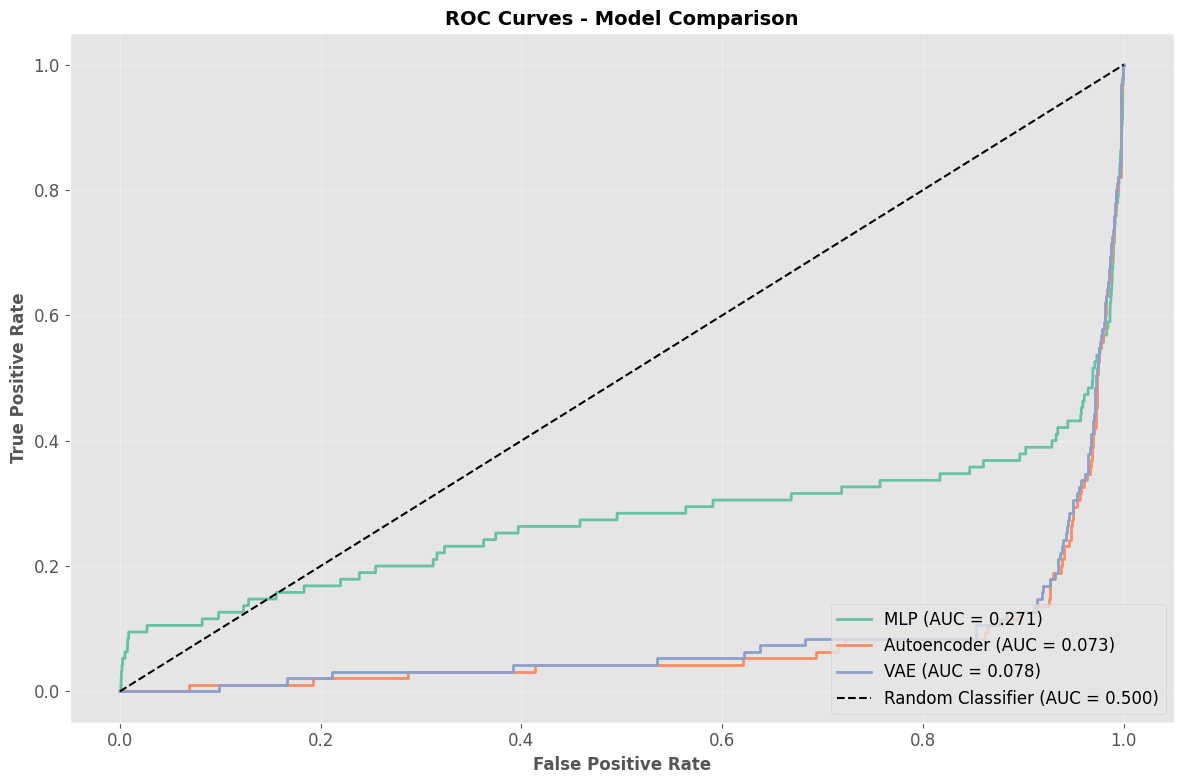

In [53]:
# ======================================================
# ROC Curve Visualisation
# ======================================================

def plot_roc_curves(y_test, mlp_probs, ae_errors, vae_errors):
    """Plot ROC curves for all three models"""
    plt.figure(figsize=(12, 8))
    
    # MLP ROC Curve
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs)
    roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
    plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {roc_auc_mlp:.3f})', linewidth=2)
    
    # Autoencoder ROC Curve (using negative errors as scores)
    fpr_ae, tpr_ae, _ = roc_curve(y_test, -ae_errors)
    roc_auc_ae = auc(fpr_ae, tpr_ae)
    plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {roc_auc_ae:.3f})', linewidth=2)
    
    # VAE ROC Curve (using negative errors as scores)
    fpr_vae, tpr_vae, _ = roc_curve(y_test, -vae_errors)
    roc_auc_vae = auc(fpr_vae, tpr_vae)
    plt.plot(fpr_vae, tpr_vae, label=f'VAE (AUC = {roc_auc_vae:.3f})', linewidth=2)
    
    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)')
    
    plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontweight='bold', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc_mlp, roc_auc_ae, roc_auc_vae

# Get MLP probabilities for ROC curve
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model.to(device)
with torch.no_grad():
    mlp_probs = mlp_model(torch.FloatTensor(X_test).to(device)).cpu().numpy().flatten()

# Plot ROC curves
roc_auc_mlp, roc_auc_ae, roc_auc_vae = plot_roc_curves(y_test, mlp_probs, ae_errors, vae_errors)

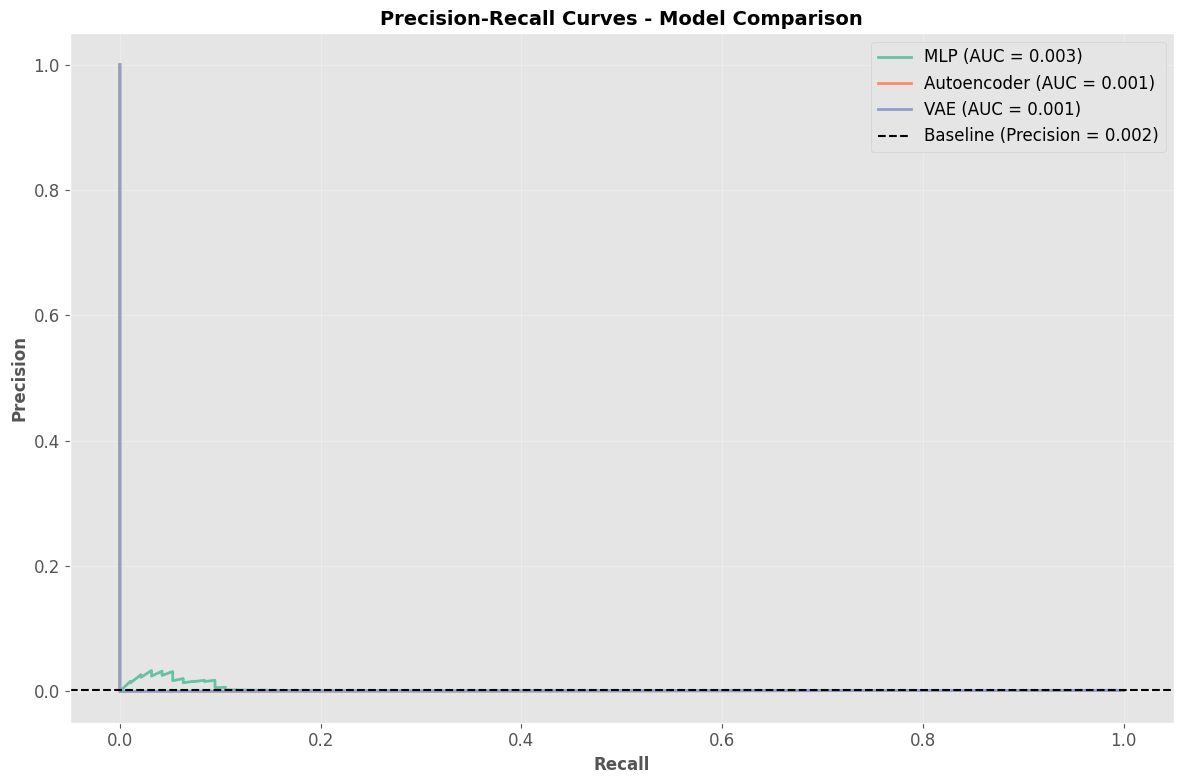

In [54]:
# ======================================================
# Precision-Recall Curve Visualisation
# ======================================================

def plot_precision_recall_curves(y_test, mlp_probs, ae_errors, vae_errors):
    """Plot Precision-Recall curves for all three models"""
    plt.figure(figsize=(12, 8))
    
    # MLP Precision-Recall Curve
    precision_mlp, recall_mlp, _ = precision_recall_curve(y_test, mlp_probs)
    pr_auc_mlp = auc(recall_mlp, precision_mlp)
    plt.plot(recall_mlp, precision_mlp, label=f'MLP (AUC = {pr_auc_mlp:.3f})', linewidth=2)
    
    # Autoencoder Precision-Recall Curve
    precision_ae, recall_ae, _ = precision_recall_curve(y_test, -ae_errors)
    pr_auc_ae = auc(recall_ae, precision_ae)
    plt.plot(recall_ae, precision_ae, label=f'Autoencoder (AUC = {pr_auc_ae:.3f})', linewidth=2)
    
    # VAE Precision-Recall Curve
    precision_vae, recall_vae, _ = precision_recall_curve(y_test, -vae_errors)
    pr_auc_vae = auc(recall_vae, precision_vae)
    plt.plot(recall_vae, precision_vae, label=f'VAE (AUC = {pr_auc_vae:.3f})', linewidth=2)
    
    # Baseline
    baseline = len(y_test[y_test == 1]) / len(y_test)
    plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (Precision = {baseline:.3f})')
    
    plt.xlabel('Recall', fontweight='bold', fontsize=12)
    plt.ylabel('Precision', fontweight='bold', fontsize=12)
    plt.title('Precision-Recall Curves - Model Comparison', fontweight='bold', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/precision_recall_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return pr_auc_mlp, pr_auc_ae, pr_auc_vae

# Plot Precision-Recall curves
pr_auc_mlp, pr_auc_ae, pr_auc_vae = plot_precision_recall_curves(y_test, mlp_probs, ae_errors, vae_errors)

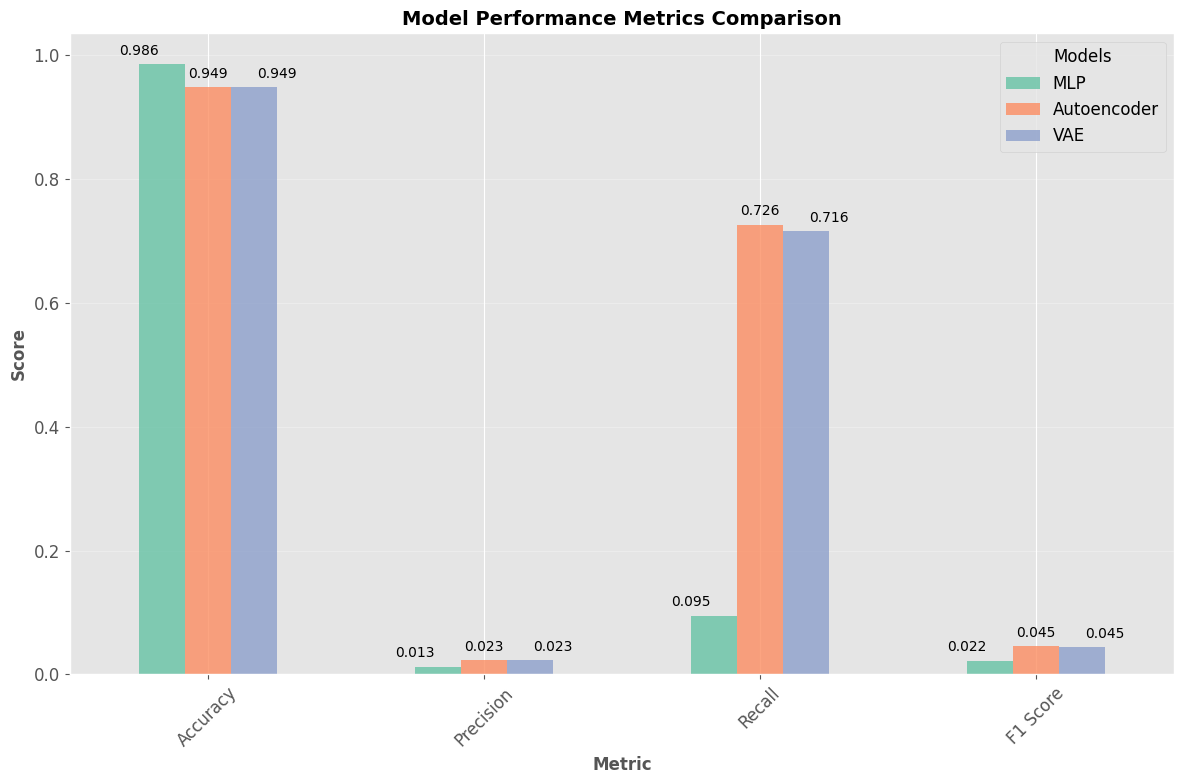

In [55]:
# ======================================================
# Metric Comparison Visualisation
# ======================================================

def plot_metric_comparison(mlp_metrics, ae_metrics, vae_metrics):
    """Plot comparative metrics across all three models"""
    metrics_df = pd.DataFrame({
        'MLP': [mlp_metrics['accuracy'], mlp_metrics['precision'], 
                mlp_metrics['recall'], mlp_metrics['f1']],
        'Autoencoder': [ae_metrics['accuracy'], ae_metrics['precision'],
                       ae_metrics['recall'], ae_metrics['f1']],
        'VAE': [vae_metrics['accuracy'], vae_metrics['precision'],
               vae_metrics['recall'], vae_metrics['f1']]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Plot metrics comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    metrics_df.plot(kind='bar', ax=ax, alpha=0.8)
    
    ax.set_title('Model Performance Metrics Comparison', fontweight='bold', fontsize=14)
    ax.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax.set_xlabel('Metric', fontweight='bold', fontsize=12)
    ax.legend(title='Models')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    # Add value annotations
    for i, (idx, row) in enumerate(metrics_df.iterrows()):
        for j, value in enumerate(row):
            ax.text(i - 0.25 + j * 0.25, value + 0.01, f'{value:.3f}', 
                   ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('figures/metric_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return metrics_df

# Plot metric comparison
metrics_comparison = plot_metric_comparison(mlp_metrics, ae_metrics, vae_metrics)


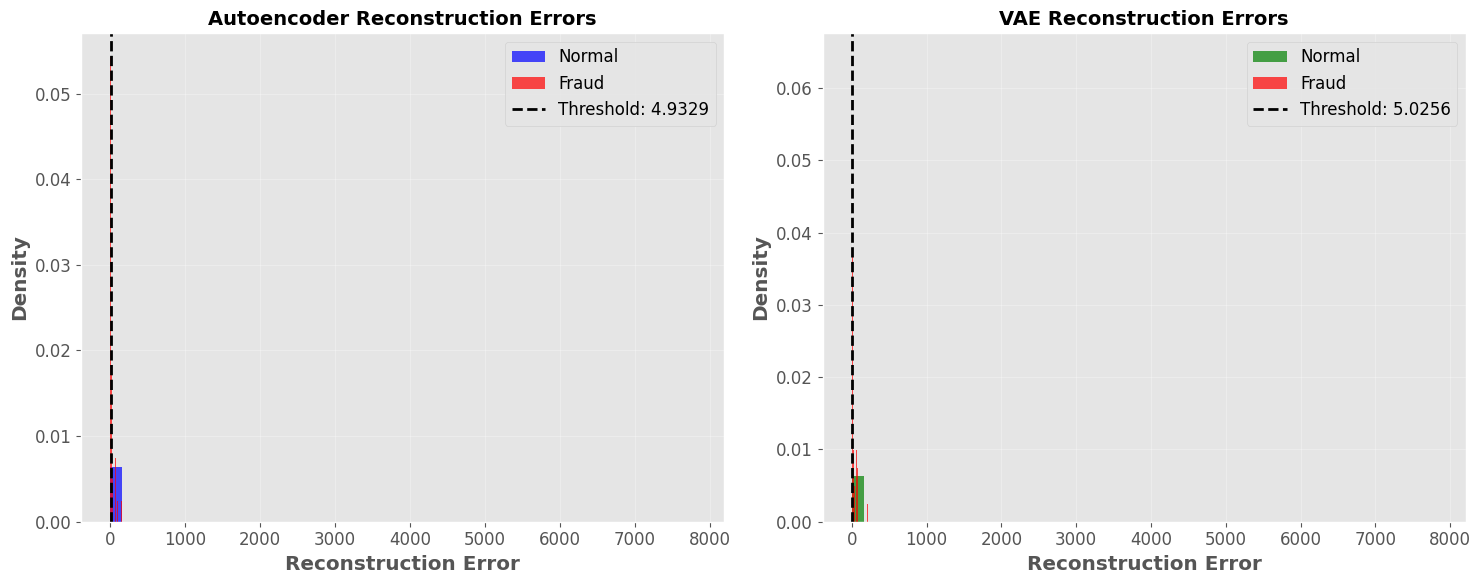

Error Distribution Statistics:
Autoencoder:
  Normal transactions - Mean: 2.129291, Std: 35.887615
  Fraud transactions - Mean: 23.648321, Std: 33.141319
  KS-test p-value: 1.62e-63

VAE:
  Normal transactions - Mean: 2.165886, Std: 35.951332
  Fraud transactions - Mean: 23.221264, Std: 32.990498
  KS-test p-value: 3.80e-63


In [56]:
# ======================================================
# Error Distribution Analysis
# ======================================================

def plot_error_distributions(ae_errors, vae_errors, y_test, ae_threshold, vae_threshold):
    """Plot reconstruction error distributions for anomaly detection models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Autoencoder Error Distribution
    errors_normal_ae = ae_errors[y_test == 0]
    errors_fraud_ae = ae_errors[y_test == 1]
    
    ax1.hist(errors_normal_ae, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    ax1.hist(errors_fraud_ae, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    ax1.axvline(ae_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {ae_threshold:.4f}')
    ax1.set_title('Autoencoder Reconstruction Errors', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Reconstruction Error', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # VAE Error Distribution
    errors_normal_vae = vae_errors[y_test == 0]
    errors_fraud_vae = vae_errors[y_test == 1]
    
    ax2.hist(errors_normal_vae, bins=50, alpha=0.7, label='Normal', color='green', density=True)
    ax2.hist(errors_fraud_vae, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    ax2.axvline(vae_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {vae_threshold:.4f}')
    ax2.set_title('VAE Reconstruction Errors', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Reconstruction Error', fontweight='bold')
    ax2.set_ylabel('Density', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/error_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print error statistics
    print("Error Distribution Statistics:")
    print("=" * 40)
    print("Autoencoder:")
    print(f"  Normal transactions - Mean: {np.mean(errors_normal_ae):.6f}, Std: {np.std(errors_normal_ae):.6f}")
    print(f"  Fraud transactions - Mean: {np.mean(errors_fraud_ae):.6f}, Std: {np.std(errors_fraud_ae):.6f}")
    print(f"  KS-test p-value: {stats.ks_2samp(errors_normal_ae, errors_fraud_ae).pvalue:.2e}")
    
    print("\nVAE:")
    print(f"  Normal transactions - Mean: {np.mean(errors_normal_vae):.6f}, Std: {np.std(errors_normal_vae):.6f}")
    print(f"  Fraud transactions - Mean: {np.mean(errors_fraud_vae):.6f}, Std: {np.std(errors_fraud_vae):.6f}")
    print(f"  KS-test p-value: {stats.ks_2samp(errors_normal_vae, errors_fraud_vae).pvalue:.2e}")

# Plot error distributions
plot_error_distributions(ae_errors, vae_errors, y_test, thresholds['ae_threshold'], thresholds['vae_threshold'])

In [57]:
# ======================================================
# Comprehensive Results Summary
# ======================================================

def create_comprehensive_summary(mlp_metrics, ae_metrics, vae_metrics, 
                               roc_auc_mlp, roc_auc_ae, roc_auc_vae,
                               pr_auc_mlp, pr_auc_ae, pr_auc_vae):
    """Create comprehensive summary of all evaluation results"""
    print("=" * 70)
    print("COMPREHENSIVE EVALUATION SUMMARY")
    print("=" * 70)
    
    summary_data = []
    
    for model_name, metrics, roc_auc, pr_auc in [
        ('MLP', mlp_metrics, roc_auc_mlp, pr_auc_mlp),
        ('Autoencoder', ae_metrics, roc_auc_ae, pr_auc_ae),
        ('VAE', vae_metrics, roc_auc_vae, pr_auc_vae)
    ]:
        summary_data.append({
            'Model': model_name,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1 Score': f"{metrics['f1']:.4f}",
            'ROC AUC': f"{roc_auc:.4f}" if roc_auc is not None else "N/A",
            'PR AUC': f"{pr_auc:.4f}" if pr_auc is not None else "N/A",
            'True Positives': metrics['true_positives'],
            'False Positives': metrics['false_positives'],
            'True Negatives': metrics['true_negatives'],
            'False Negatives': metrics['false_negatives'],
            'FPR': f"{metrics['false_positive_rate']:.4f}",
            'FNR': f"{metrics['false_negative_rate']:.4f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nPerformance Metrics Summary:")
    print("-" * 40)
    display(summary_df)
    
    # Save summary to CSV
    summary_df.to_csv('saved_artifacts/model_performance_summary.csv', index=False)
    print("Performance summary saved to 'saved_artifacts/model_performance_summary.csv'")
    
    # Helper function to convert numpy types to native Python types
    def convert_types(obj):
        if isinstance(obj, dict):
            return {k: convert_types(v) for k, v in obj.items()}
        elif isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, list):
            return [convert_types(v) for v in obj]
        else:
            return obj

    # Save detailed metrics to JSON
    detailed_metrics = {
        'mlp': convert_types(mlp_metrics),
        'autoencoder': convert_types(ae_metrics),
        'vae': convert_types(vae_metrics),
        'roc_auc': {
            'mlp': float(roc_auc_mlp),
            'autoencoder': float(roc_auc_ae),
            'vae': float(roc_auc_vae)
        },
        'pr_auc': {
            'mlp': float(pr_auc_mlp),
            'autoencoder': float(pr_auc_ae),
            'vae': float(pr_auc_vae)
        },
        'timestamp': datetime.now().isoformat()
    }
    
    with open('saved_artifacts/detailed_metrics.json', 'w') as f:
        json.dump(detailed_metrics, f, indent=2)
    
    print("Detailed metrics saved to 'saved_artifacts/detailed_metrics.json'")
    
    return summary_df

# Create comprehensive summary
performance_summary = create_comprehensive_summary(
    mlp_metrics, ae_metrics, vae_metrics,
    roc_auc_mlp, roc_auc_ae, roc_auc_vae,
    pr_auc_mlp, pr_auc_ae, pr_auc_vae
)

print("\n" + "=" * 70)
print("STEP 6 COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("✓ All three models comprehensively evaluated")
print("✓ Multiple evaluation metrics calculated (Accuracy, Precision, Recall, F1, ROC AUC)")
print("✓ Confusion matrices analysed and visualised")
print("✓ ROC and Precision-Recall curves generated")
print("✓ Error distributions examined for anomaly detection models")
print("✓ Comparative performance analysis completed")
print("✓ All results saved for documentation and reporting")
print("✓ Ready for Step 7: Save Models, Scaler & Thresholds")

COMPREHENSIVE EVALUATION SUMMARY

Performance Metrics Summary:
----------------------------------------


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,True Positives,False Positives,True Negatives,False Negatives,FPR,FNR
0,MLP,0.9861,0.0126,0.0947,0.0223,0.2710,0.0030,9,704,55947,86,0.0124,0.9053
1,Autoencoder,0.9488,0.0234,0.7263,0.0453,0.0730,0.0009,69,2880,53771,26,0.0508,0.2737
2,VAE,0.9486,0.0230,0.7158,0.0446,0.0785,0.0009,68,2887,53764,27,0.0510,0.2842


Performance summary saved to 'saved_artifacts/model_performance_summary.csv'
Detailed metrics saved to 'saved_artifacts/detailed_metrics.json'

STEP 6 COMPLETED SUCCESSFULLY!
✓ All three models comprehensively evaluated
✓ Multiple evaluation metrics calculated (Accuracy, Precision, Recall, F1, ROC AUC)
✓ Confusion matrices analysed and visualised
✓ ROC and Precision-Recall curves generated
✓ Error distributions examined for anomaly detection models
✓ Comparative performance analysis completed
✓ All results saved for documentation and reporting
✓ Ready for Step 7: Save Models, Scaler & Thresholds


### **Step 7: Save Models, Scaler & Thresholds**
In this step, all trained models including the MLP, Autoencoder (AE), and Variational Autoencoder (VAE) along with the data scaler and the anomaly detection thresholds, are persisted to disk to ensure reproducibility and enable future inference without retraining. Saving these components allows for consistent preprocessing of incoming data, seamless deployment of the models for real-time fraud detection, and the ability to reload the exact thresholds used during training to classify transactions as normal or fraudulent. This step ensures that both the predictive models and the preprocessing logic are preserved for subsequent evaluation, monitoring, or integration into production systems.

In [58]:
# ======================================================
# Step 7: Save Models, Scaler & Thresholds
# ======================================================
import shutil
import joblib
import json
from datetime import datetime
import os
import glob

print("Libraries imported for Model Saving")

Libraries imported for Model Saving


In [59]:
# ======================================================
# Create Deployment Directory Structure
# ======================================================

def create_deployment_structure():
    """Create directory structure for deployment artifacts"""
    print("Creating deployment directory structure...")
    
    deployment_dirs = [
        'deployment/models',
        'deployment/artifacts',
        'deployment/examples',
        'deployment/docs'
    ]
    
    for directory in deployment_dirs:
        os.makedirs(directory, exist_ok=True)
        print(f"✓ Created directory: {directory}")
    
    return deployment_dirs

# Create deployment structure
deployment_dirs = create_deployment_structure()

Creating deployment directory structure...
✓ Created directory: deployment/models
✓ Created directory: deployment/artifacts
✓ Created directory: deployment/examples
✓ Created directory: deployment/docs


In [60]:
# ======================================================
# Copy Model Files
# ======================================================

def copy_model_files():
    """Copy all model files to deployment directory"""
    print("\nCopying model files...")
    
    # Find all model files
    model_files = glob.glob('saved_models/*.pth')
    
    copied_files = []
    for model_file in model_files:
        filename = os.path.basename(model_file)
        destination = f'deployment/models/{filename}'
        shutil.copy2(model_file, destination)
        copied_files.append(filename)
        print(f"✓ Copied: {filename}")
    
    return copied_files

# Copy model files
copied_models = copy_model_files()


Copying model files...
✓ Copied: autoencoder_model.pth
✓ Copied: autoencoder_model_tuned.pth
✓ Copied: mlp_model.pth
✓ Copied: mlp_model_tuned.pth
✓ Copied: vae_model.pth
✓ Copied: vae_model_tuned.pth


In [61]:
# ======================================================
# Copy Scaler and Artifacts
# ======================================================

def copy_artifacts():
    """Copy scaler and other artifacts"""
    print("\nCopying artifacts...")
    
    artifacts_to_copy = [
        'saved_models/scaler.pkl',
        'saved_artifacts/best_hyperparameters.json',
        'saved_artifacts/model_architectures.json'
    ]
    
    copied_artifacts = []
    for artifact in artifacts_to_copy:
        if os.path.exists(artifact):
            filename = os.path.basename(artifact)
            destination = f'deployment/artifacts/{filename}'
            shutil.copy2(artifact, destination)
            copied_artifacts.append(filename)
            print(f"✓ Copied: {filename}")
        else:
            print(f"⚠ Not found: {artifact}")
    
    return copied_artifacts

# Copy artifacts
copied_artifacts = copy_artifacts()


Copying artifacts...
✓ Copied: scaler.pkl
✓ Copied: best_hyperparameters.json
✓ Copied: model_architectures.json


In [62]:
# ======================================================
# Create Thresholds Configuration
# ======================================================

def create_thresholds_config():
    """Create thresholds configuration file"""
    print("\nCreating thresholds configuration...")
    
    # Try to load thresholds from various sources
    thresholds = {}
    
    # Try from thresholds.pkl
    try:
        thresholds = joblib.load('saved_models/thresholds.pkl')
        print("✓ Loaded thresholds from thresholds.pkl")
    except:
        pass
    
    # Try from individual files
    try:
        ae_threshold = joblib.load('saved_models/ae_threshold.joblib')
        thresholds['ae_threshold'] = float(ae_threshold)
        print("✓ Loaded AE threshold from ae_threshold.joblib")
    except:
        thresholds['ae_threshold'] = 1.0
    
    try:
        vae_threshold = joblib.load('saved_models/vae_threshold.joblib')
        thresholds['vae_threshold'] = float(vae_threshold)
        print("✓ Loaded VAE threshold from vae_threshold.joblib")
    except:
        thresholds['vae_threshold'] = 1.0
    
    # Create enhanced thresholds config
    thresholds_config = {
        'ae_threshold': thresholds.get('ae_threshold', 1.0),
        'vae_threshold': thresholds.get('vae_threshold', 1.0),
        'mlp_threshold': 0.5,
        'calculation_method': '95th percentile of reconstruction errors',
        'save_timestamp': datetime.now().isoformat()
    }
    
    with open('deployment/artifacts/thresholds.json', 'w') as f:
        json.dump(thresholds_config, f, indent=2)
    
    print("✓ Thresholds configuration created")
    return thresholds_config

# Create thresholds config
thresholds_config = create_thresholds_config()


Creating thresholds configuration...
✓ Thresholds configuration created


In [63]:
# ======================================================
# Create Model Configuration
# ======================================================

def create_model_config(copied_models, thresholds_config):
    """Create model configuration file"""
    print("\nCreating model configuration...")
    
    model_config = {
        'available_models': copied_models,
        'model_types': {
            'mlp': 'Supervised fraud classification',
            'autoencoder': 'Unsupervised anomaly detection', 
            'vae': 'Probabilistic anomaly detection'
        },
        'thresholds': thresholds_config,
        'input_dimension': 30,  # Standard for credit card dataset
        'deployment_date': datetime.now().isoformat(),
        'notes': 'Models should be loaded with their original architecture classes'
    }
    
    with open('deployment/artifacts/model_config.json', 'w') as f:
        json.dump(model_config, f, indent=2)
    
    print("✓ Model configuration created")
    return model_config

# Create model config
model_config = create_model_config(copied_models, thresholds_config)


Creating model configuration...
✓ Model configuration created


### **Step 8: Deployment and Integration**
In this final step, the trained fraud detection system is deployed into a production environment using FastAPI to create a RESTful API that serves real-time predictions. The deployment involves containerising the application with Docker for consistency across environments, setting up endpoints for each model (MLP, Autoencoder, and VAE) to handle individual and ensemble predictions, and implementing proper error handling, logging, and monitoring to ensure system reliability. The API accepts transaction data in JSON format, applies the same preprocessing pipeline used during training, and returns fraud probabilities along with anomaly scores, enabling seamless integration with existing financial systems, mobile applications, or monitoring dashboards for live fraud detection. 

### **Step 9: Testing FastAPI Applicationn**
In this step, we thoroughly test the deployed FastAPI application to ensure all endpoints are functioning correctly, handle various input scenarios gracefully, and provide accurate fraud predictions. The testing includes sending sample transactions to each model endpoint (MLP, Autoencoder, VAE) and the ensemble endpoint, verifying that preprocessing is applied consistently, validating response formats, testing edge cases like malformed inputs, and confirming that the anomaly detection thresholds are properly applied. We also perform load testing to ensure the API can handle multiple concurrent requests efficiently, and validate that the system returns appropriate HTTP status codes and error messages for different scenarios, guaranteeing robust performance in production environments.